In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Networks

## Discriminator

In [2]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))

    return model

## Generator

In [3]:
n_qubits = 4
size = 100
q_depth = 2

In [4]:
dev = qml.device("default.qubit", wires= n_qubits)

In [5]:
@qml.qnode(dev, interface="tf")
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits),rotation= qml.RY)
    return qml.probs(wires=range(n_qubits))

In [6]:
weight_shapes = {"weights": (q_depth, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=16)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(qlayer)

    return model

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [9]:
noise = tf.random.normal([100, 4])

In [10]:
generator(noise)

<tf.Tensor: shape=(100, 16), dtype=float64, numpy=
array([[1.86477547e-01, 1.00639850e-03, 1.10751760e-01, ...,
        4.76244195e-01, 1.28048916e-03, 3.24087080e-02],
       [1.46239702e-02, 1.35070164e-01, 1.00366971e-03, ...,
        8.90800511e-03, 9.91514793e-03, 1.55430993e-01],
       [1.50909704e-01, 5.77632438e-02, 5.76857710e-03, ...,
        1.30610161e-01, 7.42046250e-02, 6.13208596e-02],
       ...,
       [2.05877981e-01, 2.92883586e-03, 1.19284456e-01, ...,
        3.82445098e-01, 4.66533675e-02, 2.53607223e-02],
       [5.32561620e-01, 2.07643338e-05, 1.48302511e-03, ...,
        6.13800719e-05, 1.71521704e-03, 1.74787074e-01],
       [4.77630412e-01, 1.43692400e-02, 1.29287382e-02, ...,
        2.33909794e-02, 5.17402126e-02, 7.41277360e-02]])>

# Cost function

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(0.0005)
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)

# Training

In [15]:
EPOCHS = 400
noise_dim = n_qubits
num_examples_to_generate = 100
#BUFFER_SIZE = 60000
BATCH_SIZE = 100

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        test_data = generator(seed, training=False).numpy()
        test_data = np.argmax(test_data,1)
        plt.hist(test_data , bins = 16,  range=(0, 16), alpha=0.5, weights=np.ones(len(test_data)) / len(test_data))
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.show()
        
        for n_batch, batch in enumerate(dataset):
            X_batch = tf.convert_to_tensor(batch.numpy())
            train_step(X_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs, seed)

# Data

In [18]:
# Number training data samples
N = 10000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

In [19]:
bins = np.linspace(0, 15, num=16 )
bin_indices = np.digitize(data, bins) - 1

In [20]:
data_temp = ((np.arange(16) == bin_indices[:,None]).astype(int))

(array([1608., 2203., 1588., 1119.,  799.,  578.,  390.,  320.,  216.,
         201.,  165.,  121.,  117.,   76.,   65.,  434.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <BarContainer object of 16 artists>)

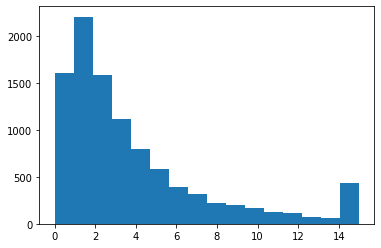

In [21]:
plt.hist(bin_indices, bins = 16)

In [22]:
data_loader = DataLoader(data_temp, batch_size=BATCH_SIZE, shuffle=True)

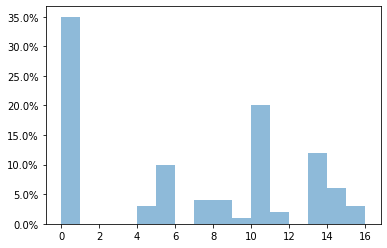

Time for epoch 1 is 328.26783204078674 sec


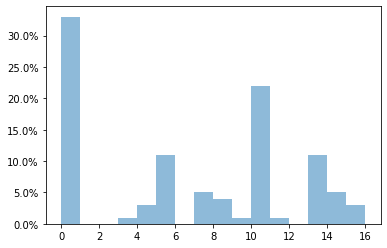

Time for epoch 2 is 5.325833320617676 sec


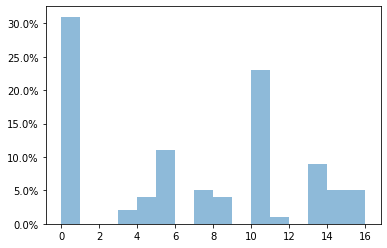

Time for epoch 3 is 5.222490310668945 sec


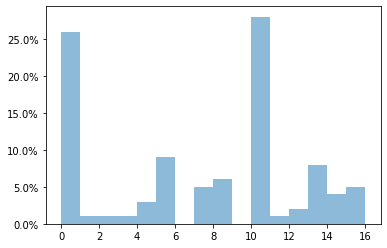

Time for epoch 4 is 5.003175973892212 sec


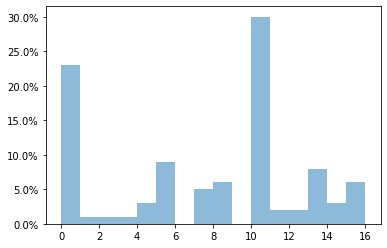

Time for epoch 5 is 4.982605457305908 sec


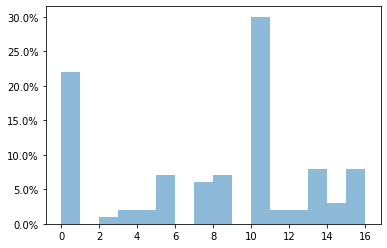

Time for epoch 6 is 5.138058185577393 sec


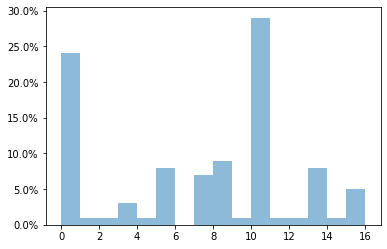

Time for epoch 7 is 4.979767322540283 sec


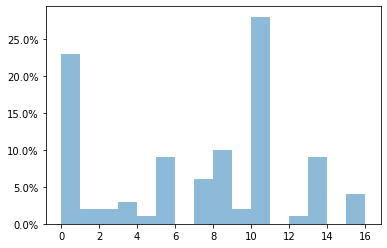

Time for epoch 8 is 5.599522829055786 sec


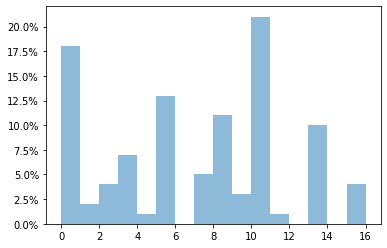

Time for epoch 9 is 5.456063508987427 sec


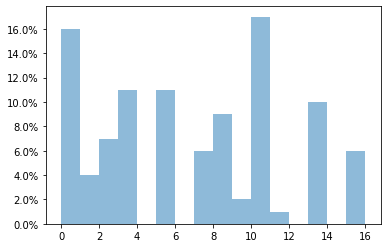

Time for epoch 10 is 4.985079526901245 sec


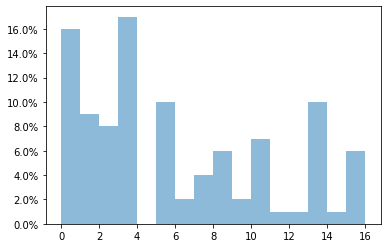

Time for epoch 11 is 5.52226448059082 sec


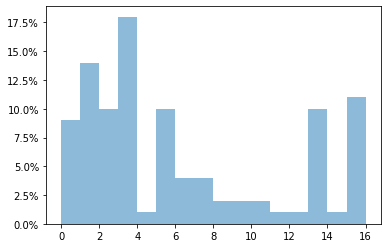

Time for epoch 12 is 5.862071990966797 sec


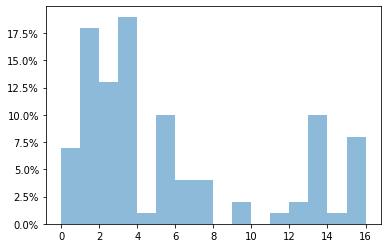

Time for epoch 13 is 5.592822790145874 sec


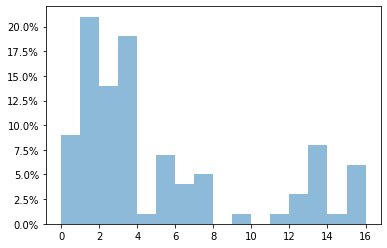

Time for epoch 14 is 5.204318046569824 sec


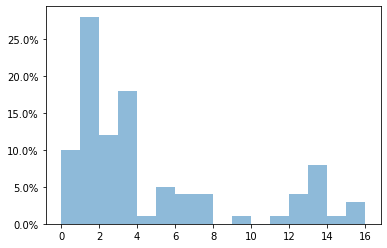

Time for epoch 15 is 5.108644008636475 sec


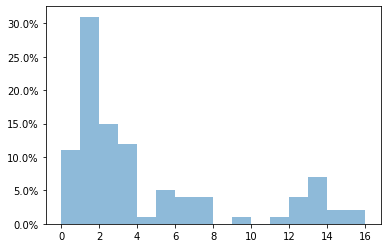

Time for epoch 16 is 5.613565921783447 sec


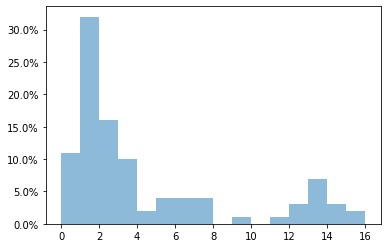

Time for epoch 17 is 5.6324687004089355 sec


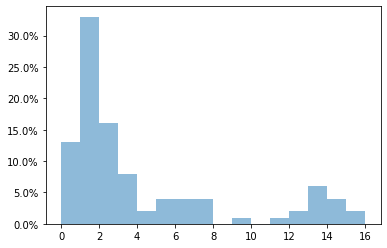

Time for epoch 18 is 5.669839143753052 sec


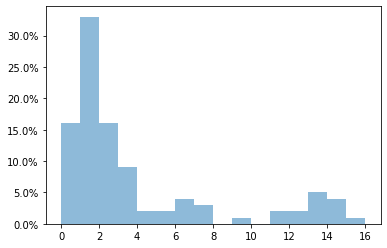

Time for epoch 19 is 5.145689964294434 sec


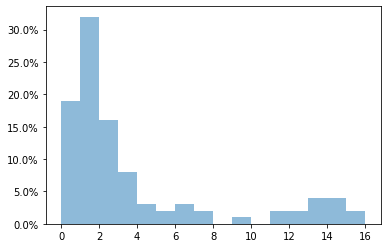

Time for epoch 20 is 5.030944347381592 sec


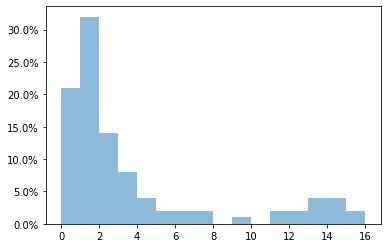

Time for epoch 21 is 5.934305667877197 sec


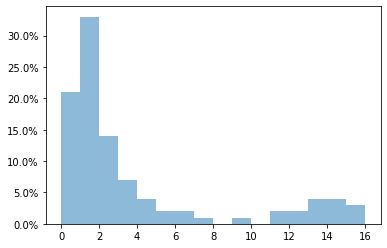

Time for epoch 22 is 5.273013591766357 sec


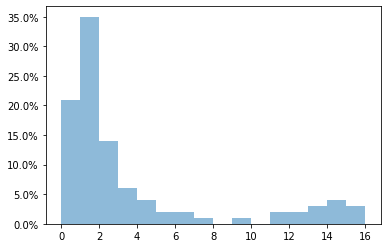

Time for epoch 23 is 5.061609506607056 sec


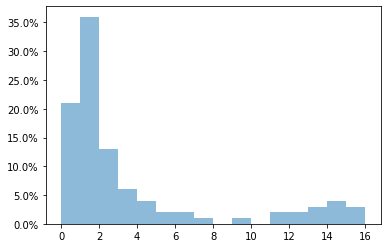

Time for epoch 24 is 5.133049726486206 sec


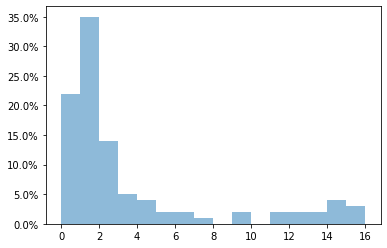

Time for epoch 25 is 4.983266353607178 sec


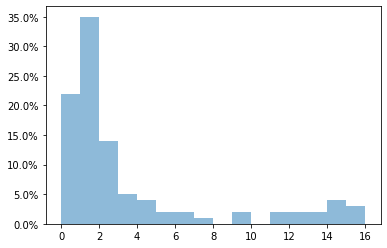

Time for epoch 26 is 4.943059921264648 sec


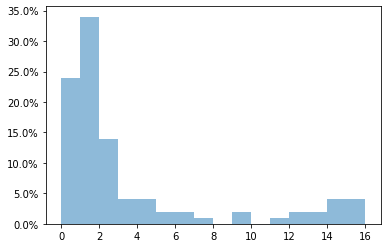

Time for epoch 27 is 5.077498435974121 sec


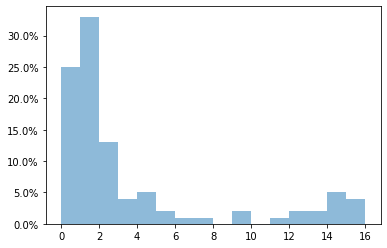

Time for epoch 28 is 4.971100091934204 sec


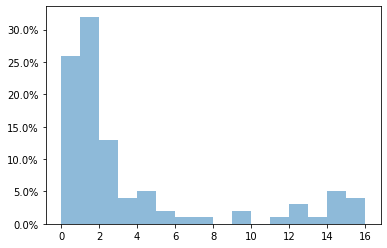

Time for epoch 29 is 4.9732115268707275 sec


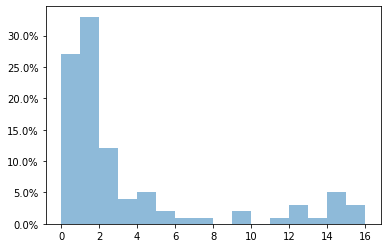

Time for epoch 30 is 5.839146375656128 sec


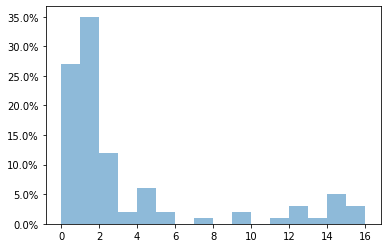

Time for epoch 31 is 5.631137371063232 sec


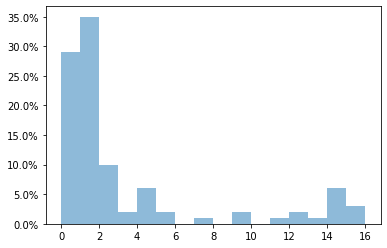

Time for epoch 32 is 5.218370676040649 sec


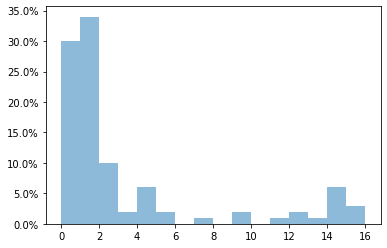

Time for epoch 33 is 5.205435752868652 sec


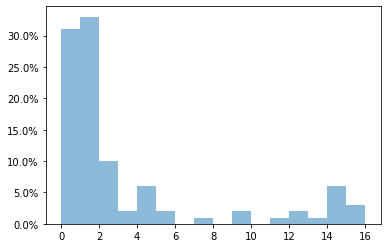

Time for epoch 34 is 4.9931252002716064 sec


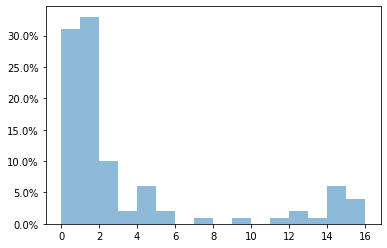

Time for epoch 35 is 4.9775779247283936 sec


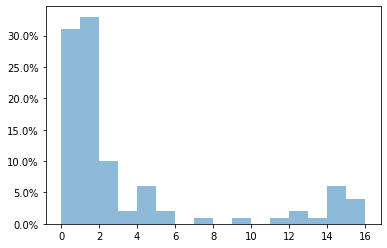

Time for epoch 36 is 5.040700674057007 sec


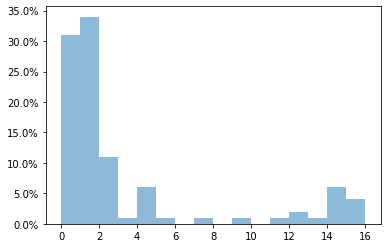

Time for epoch 37 is 5.021210193634033 sec


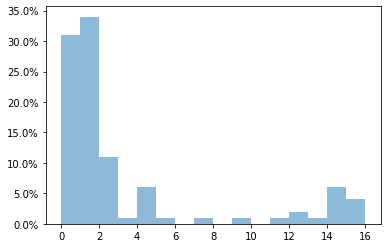

Time for epoch 38 is 4.95180082321167 sec


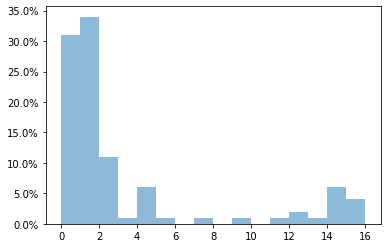

Time for epoch 39 is 4.9255571365356445 sec


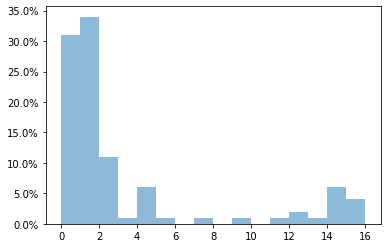

Time for epoch 40 is 5.0533647537231445 sec


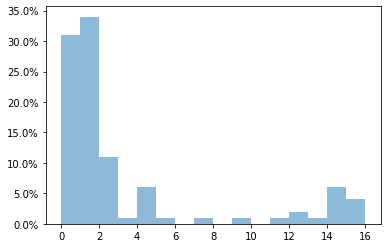

Time for epoch 41 is 4.9651713371276855 sec


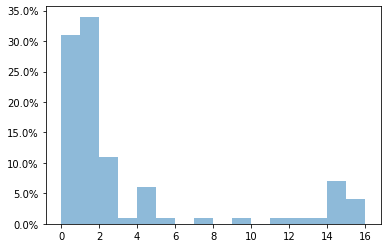

Time for epoch 42 is 4.978372812271118 sec


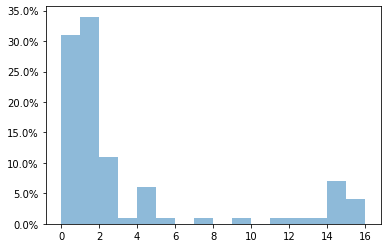

Time for epoch 43 is 5.101155996322632 sec


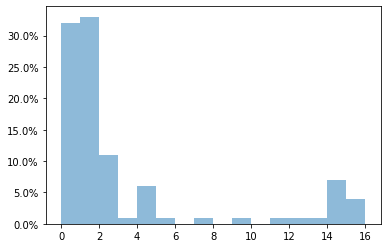

Time for epoch 44 is 5.0139000415802 sec


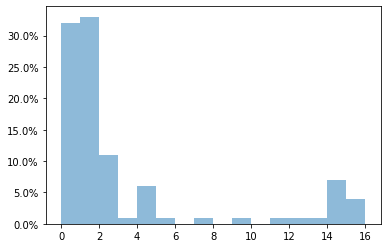

Time for epoch 45 is 5.65968132019043 sec


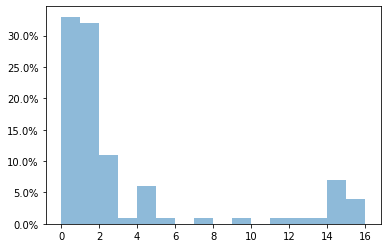

Time for epoch 46 is 5.578980445861816 sec


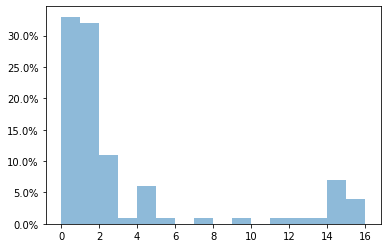

Time for epoch 47 is 4.965837240219116 sec


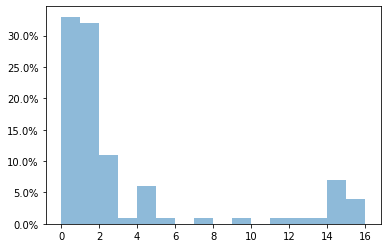

Time for epoch 48 is 4.930368423461914 sec


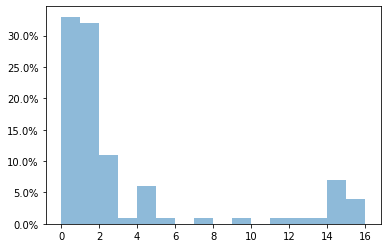

Time for epoch 49 is 5.069321870803833 sec


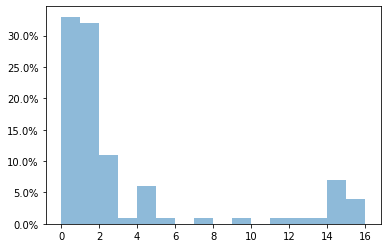

Time for epoch 50 is 4.967042446136475 sec


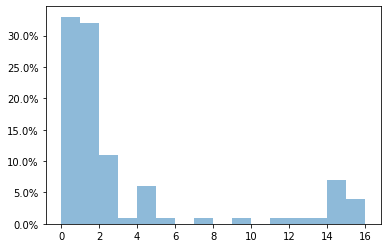

Time for epoch 51 is 5.020341396331787 sec


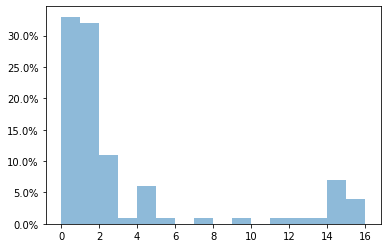

Time for epoch 52 is 5.235050916671753 sec


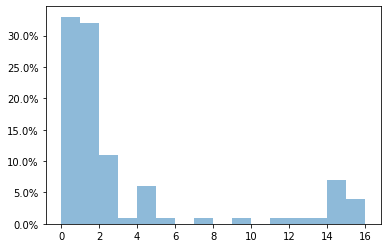

Time for epoch 53 is 4.978056907653809 sec


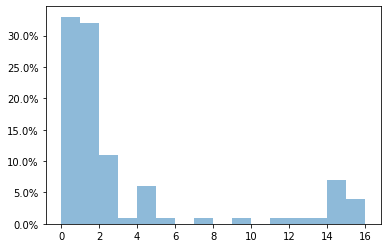

Time for epoch 54 is 5.014187335968018 sec


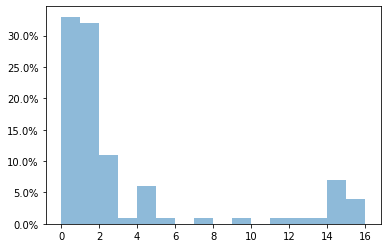

Time for epoch 55 is 5.145711421966553 sec


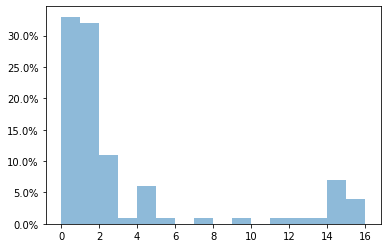

Time for epoch 56 is 4.919035196304321 sec


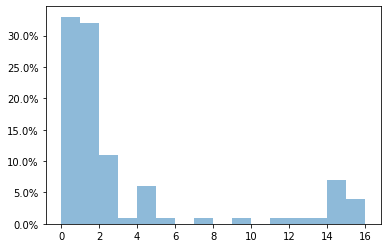

Time for epoch 57 is 4.966213226318359 sec


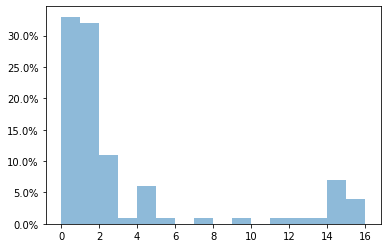

Time for epoch 58 is 4.986287832260132 sec


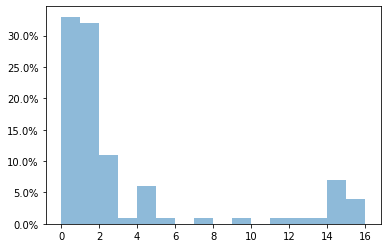

Time for epoch 59 is 5.046595573425293 sec


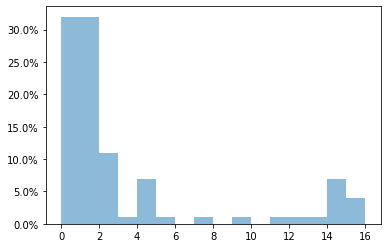

Time for epoch 60 is 4.982975244522095 sec


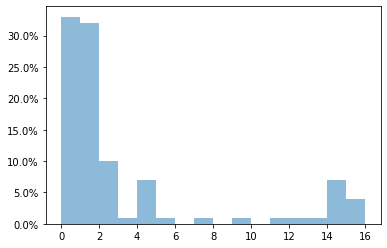

Time for epoch 61 is 4.966376781463623 sec


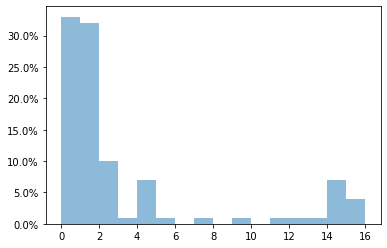

Time for epoch 62 is 4.97949481010437 sec


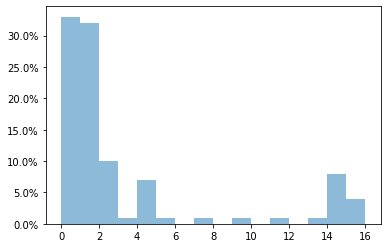

Time for epoch 63 is 4.991611480712891 sec


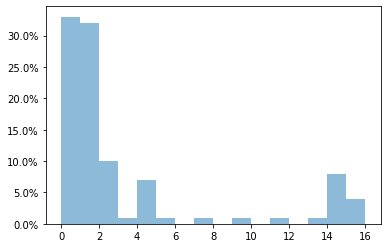

Time for epoch 64 is 5.00527811050415 sec


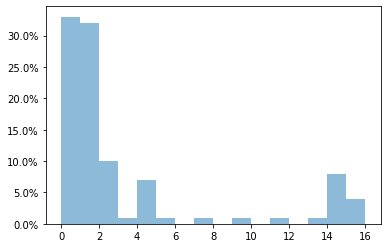

Time for epoch 65 is 5.083327293395996 sec


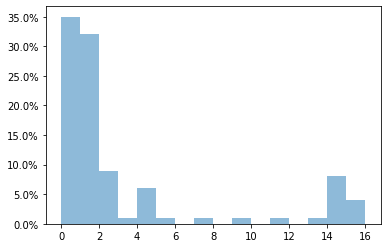

Time for epoch 66 is 5.010858058929443 sec


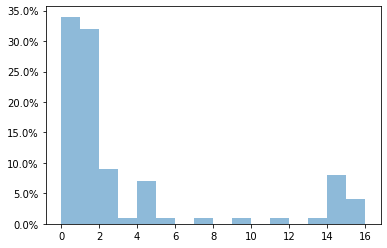

Time for epoch 67 is 5.006361246109009 sec


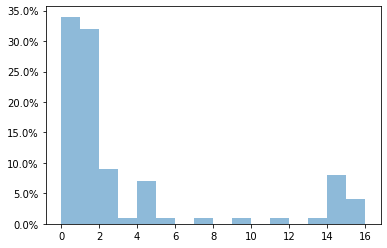

Time for epoch 68 is 5.095264196395874 sec


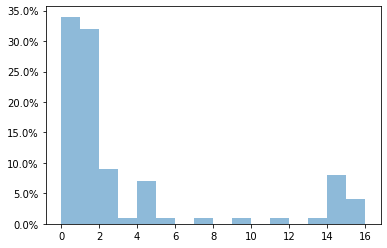

Time for epoch 69 is 4.904561996459961 sec


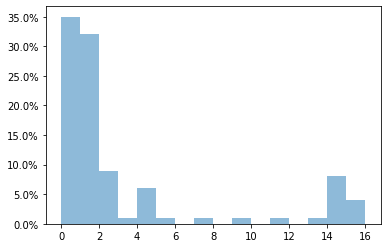

Time for epoch 70 is 4.922032594680786 sec


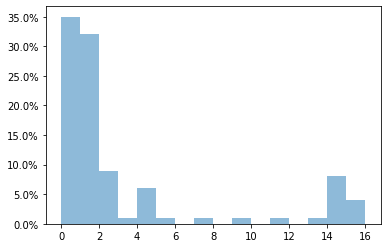

Time for epoch 71 is 5.004524230957031 sec


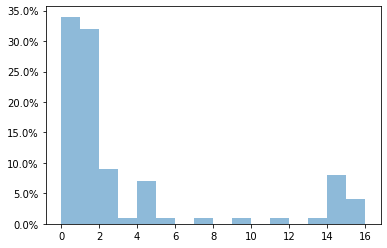

Time for epoch 72 is 4.939697504043579 sec


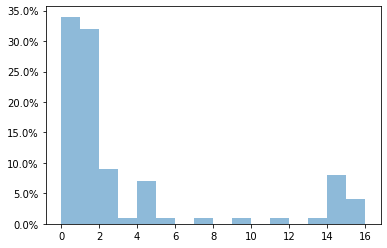

Time for epoch 73 is 4.921884536743164 sec


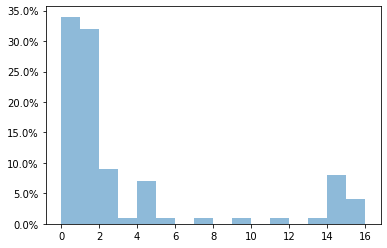

Time for epoch 74 is 4.944746971130371 sec


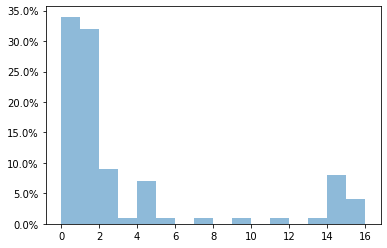

Time for epoch 75 is 4.977569341659546 sec


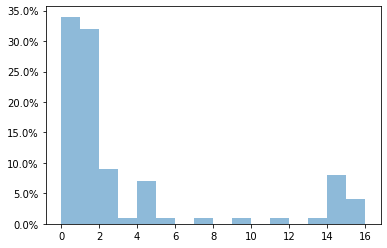

Time for epoch 76 is 4.932180404663086 sec


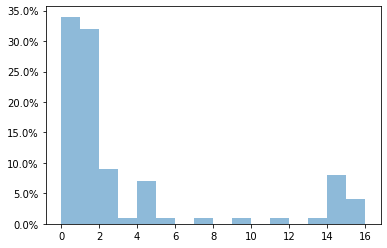

Time for epoch 77 is 4.903613328933716 sec


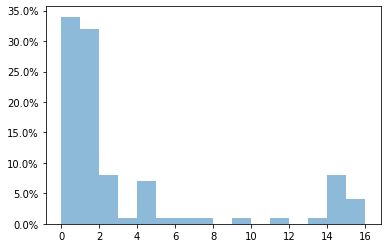

Time for epoch 78 is 5.116982936859131 sec


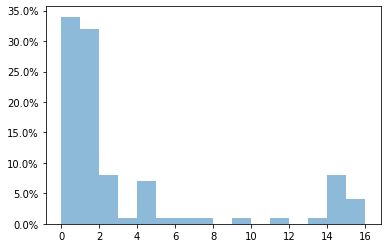

Time for epoch 79 is 5.249833345413208 sec


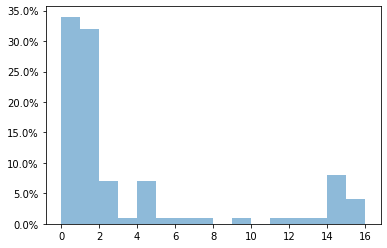

Time for epoch 80 is 5.59682559967041 sec


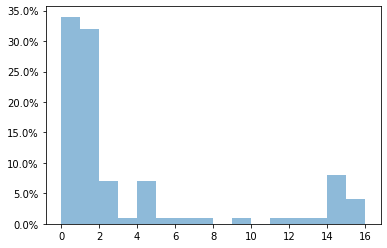

Time for epoch 81 is 5.262387275695801 sec


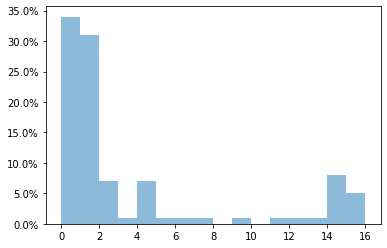

Time for epoch 82 is 5.443272829055786 sec


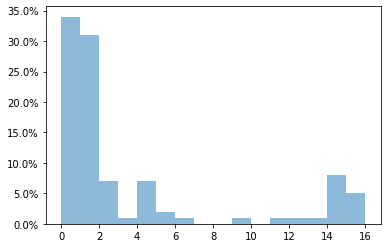

Time for epoch 83 is 4.980424880981445 sec


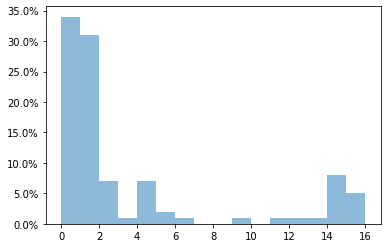

Time for epoch 84 is 5.088619709014893 sec


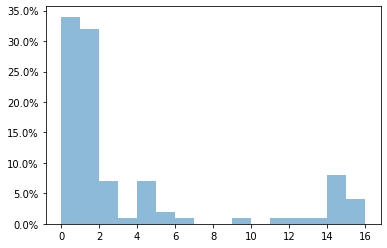

Time for epoch 85 is 4.937432050704956 sec


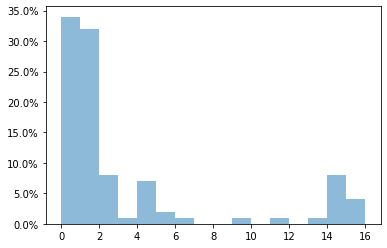

Time for epoch 86 is 5.011014223098755 sec


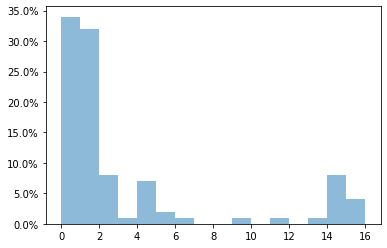

Time for epoch 87 is 5.0394532680511475 sec


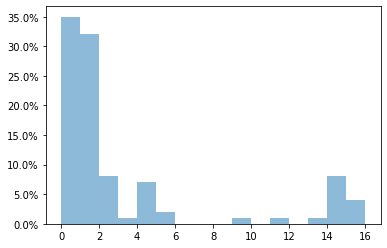

Time for epoch 88 is 4.984190464019775 sec


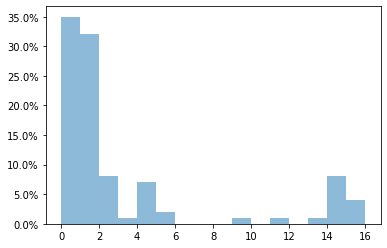

Time for epoch 89 is 4.95061731338501 sec


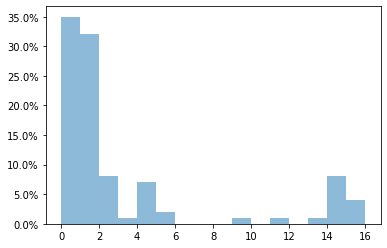

Time for epoch 90 is 5.00656795501709 sec


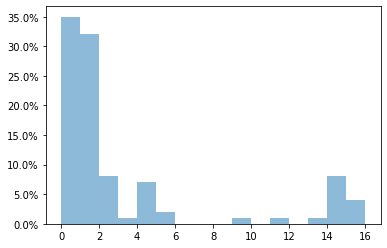

Time for epoch 91 is 5.012582778930664 sec


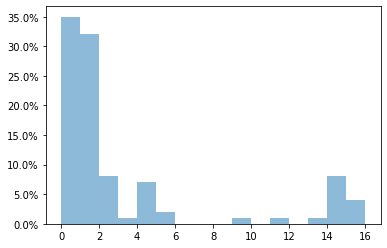

Time for epoch 92 is 4.991066932678223 sec


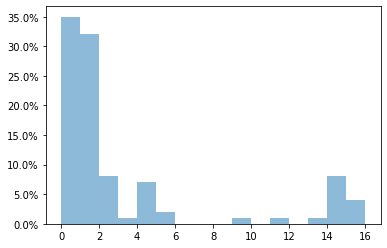

Time for epoch 93 is 4.921264410018921 sec


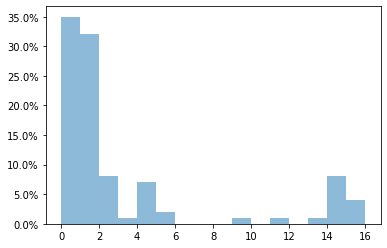

Time for epoch 94 is 5.067973613739014 sec


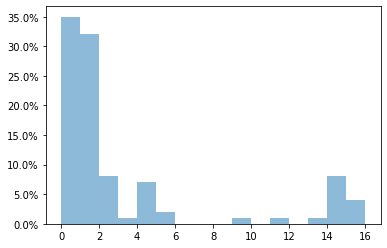

Time for epoch 95 is 4.927258491516113 sec


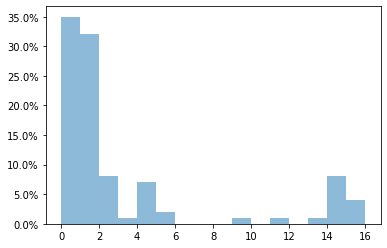

Time for epoch 96 is 4.954771518707275 sec


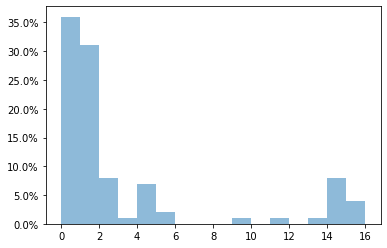

Time for epoch 97 is 5.160208225250244 sec


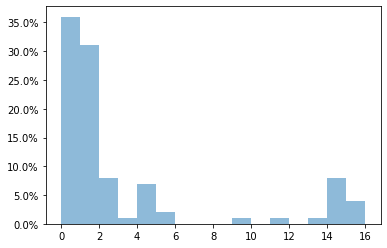

Time for epoch 98 is 4.996151685714722 sec


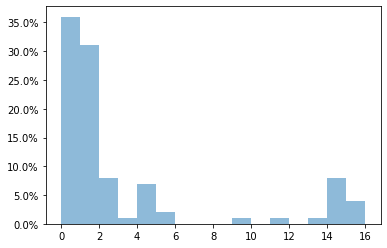

Time for epoch 99 is 4.9550909996032715 sec


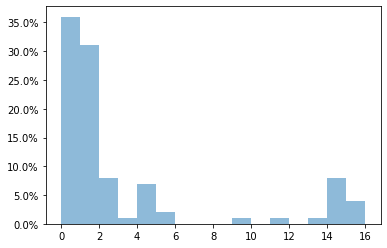

Time for epoch 100 is 6.783850908279419 sec


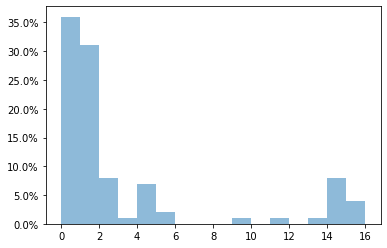

Time for epoch 101 is 4.997179746627808 sec


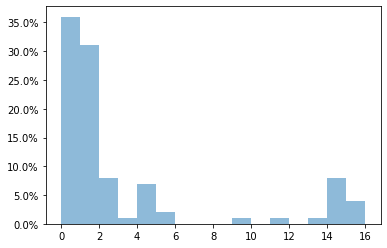

Time for epoch 102 is 4.926179647445679 sec


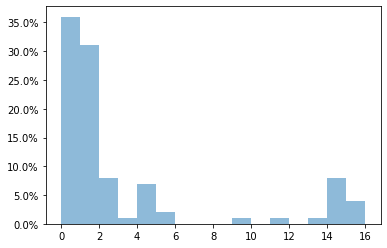

Time for epoch 103 is 5.061773300170898 sec


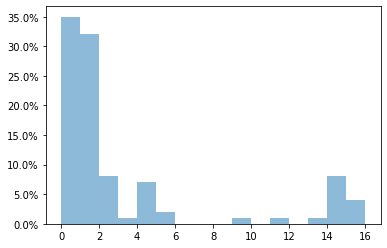

Time for epoch 104 is 5.22040057182312 sec


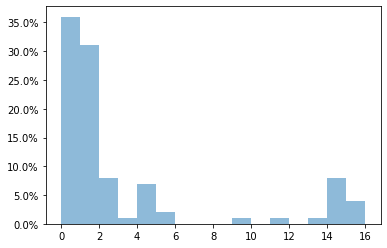

Time for epoch 105 is 5.578760147094727 sec


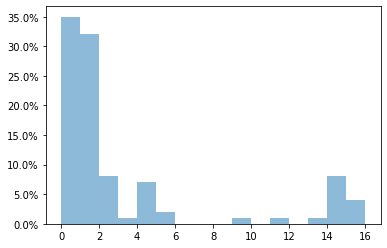

Time for epoch 106 is 5.617628335952759 sec


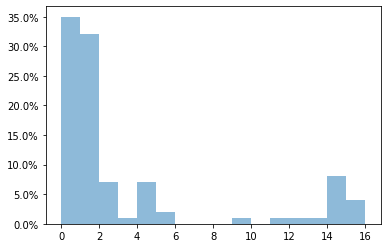

Time for epoch 107 is 4.970890045166016 sec


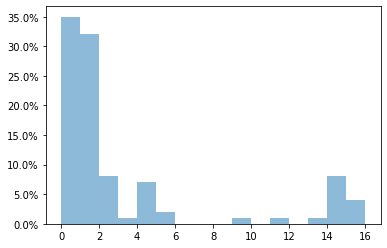

Time for epoch 108 is 4.965412139892578 sec


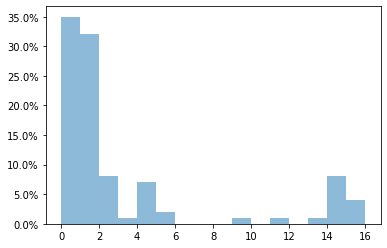

Time for epoch 109 is 5.0840003490448 sec


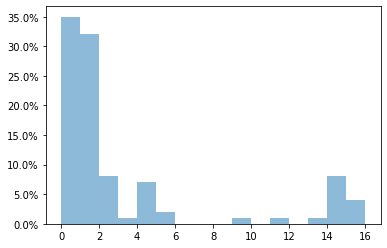

Time for epoch 110 is 4.978273391723633 sec


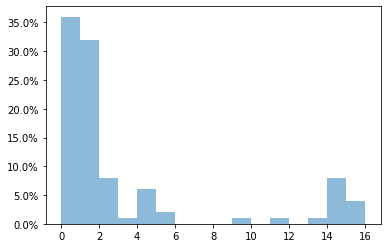

Time for epoch 111 is 4.982534408569336 sec


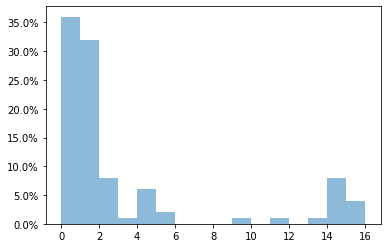

Time for epoch 112 is 5.018464803695679 sec


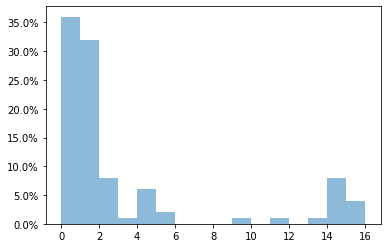

Time for epoch 113 is 5.037442922592163 sec


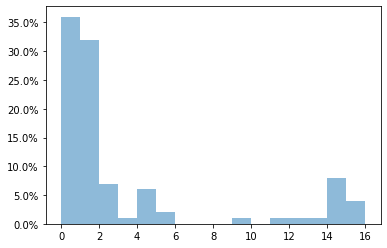

Time for epoch 114 is 5.009771823883057 sec


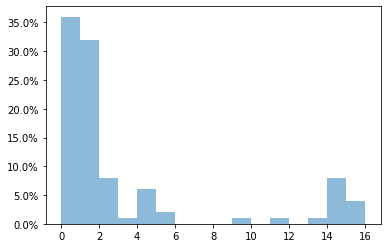

Time for epoch 115 is 5.211816072463989 sec


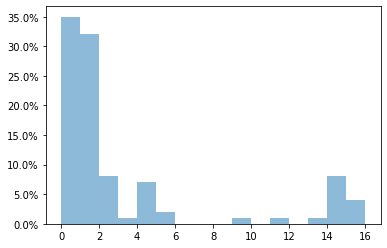

Time for epoch 116 is 4.977552652359009 sec


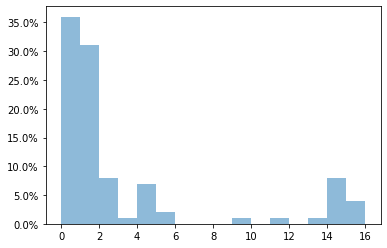

Time for epoch 117 is 5.013462543487549 sec


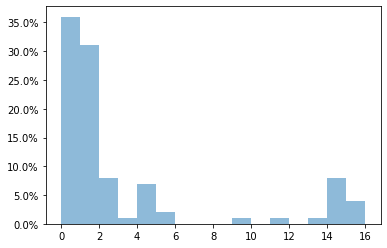

Time for epoch 118 is 5.057163715362549 sec


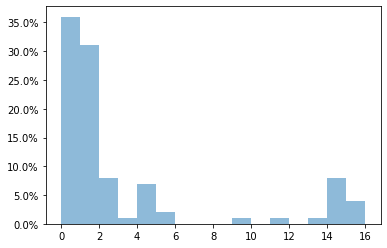

Time for epoch 119 is 5.4678566455841064 sec


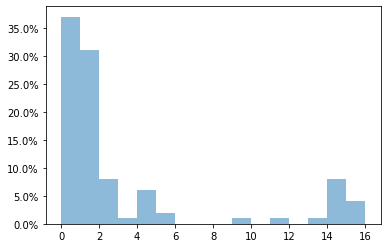

Time for epoch 120 is 5.656269311904907 sec


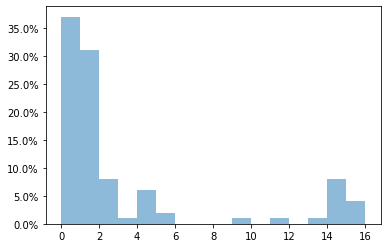

Time for epoch 121 is 5.65293550491333 sec


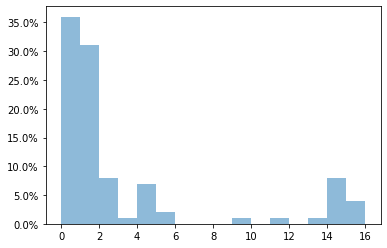

Time for epoch 122 is 5.622143983840942 sec


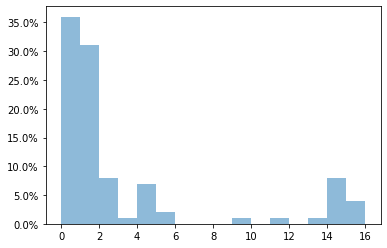

Time for epoch 123 is 5.645672798156738 sec


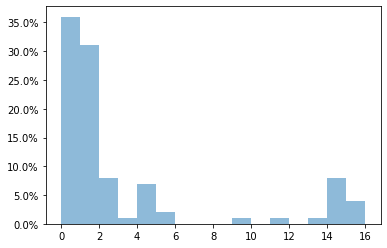

Time for epoch 124 is 5.5283143520355225 sec


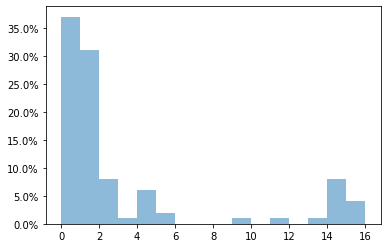

Time for epoch 125 is 4.984975099563599 sec


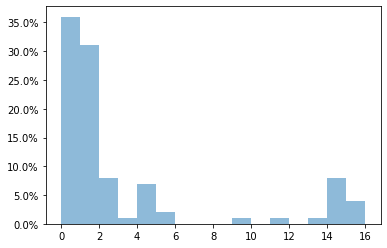

Time for epoch 126 is 4.981391429901123 sec


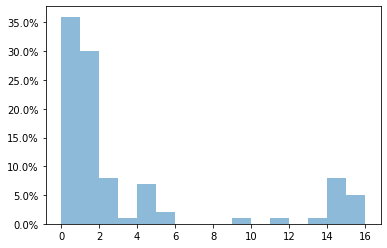

Time for epoch 127 is 5.048694133758545 sec


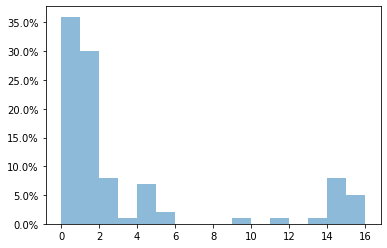

Time for epoch 128 is 4.984468936920166 sec


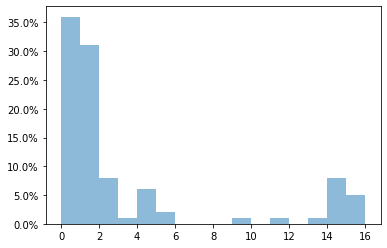

Time for epoch 129 is 4.979747295379639 sec


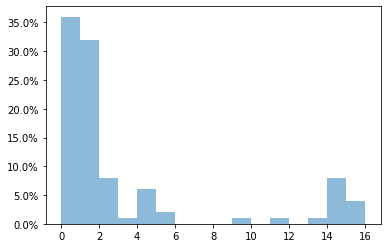

Time for epoch 130 is 5.027678728103638 sec


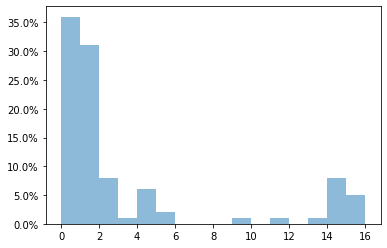

Time for epoch 131 is 4.983595371246338 sec


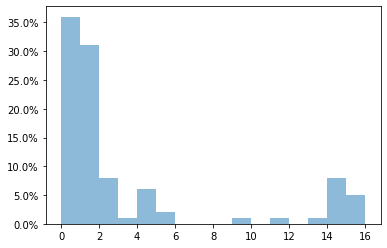

Time for epoch 132 is 4.95534348487854 sec


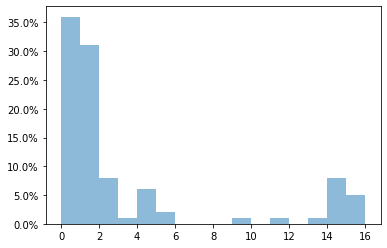

Time for epoch 133 is 4.893486261367798 sec


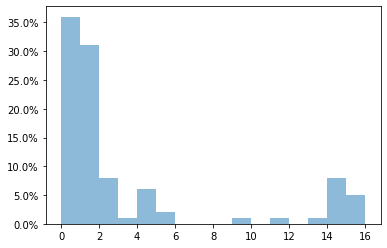

Time for epoch 134 is 5.027422666549683 sec


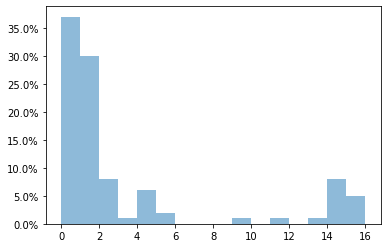

Time for epoch 135 is 4.971492052078247 sec


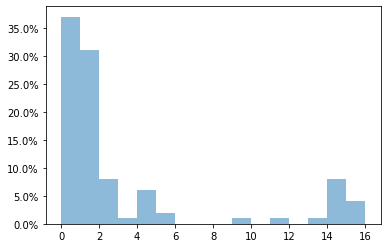

Time for epoch 136 is 4.940510511398315 sec


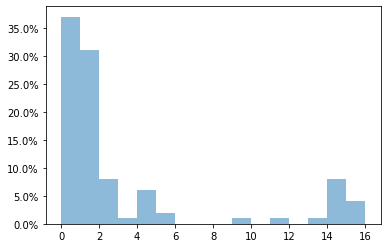

Time for epoch 137 is 5.0563671588897705 sec


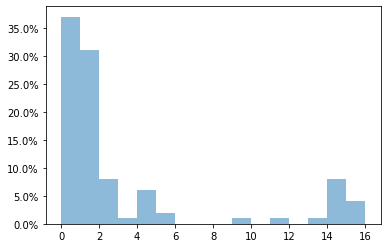

Time for epoch 138 is 5.055193901062012 sec


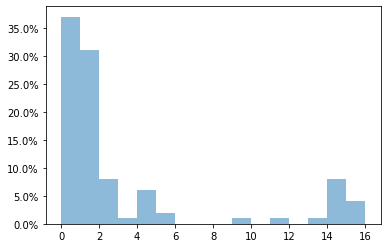

Time for epoch 139 is 4.9388720989227295 sec


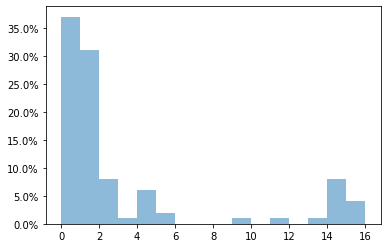

Time for epoch 140 is 5.031089782714844 sec


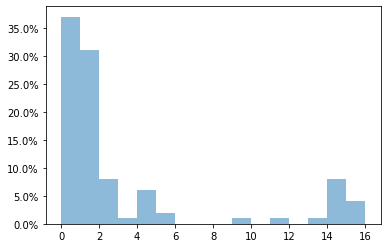

Time for epoch 141 is 4.983216762542725 sec


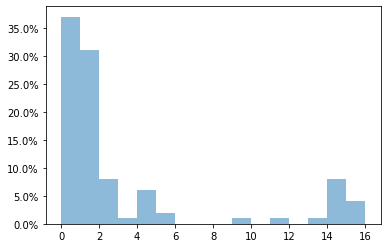

Time for epoch 142 is 4.9862589836120605 sec


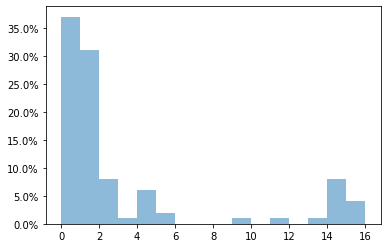

Time for epoch 143 is 5.06217360496521 sec


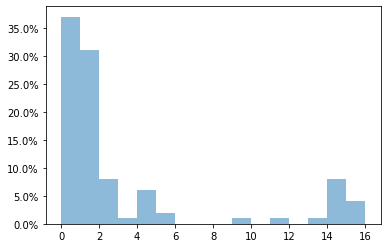

Time for epoch 144 is 4.99599289894104 sec


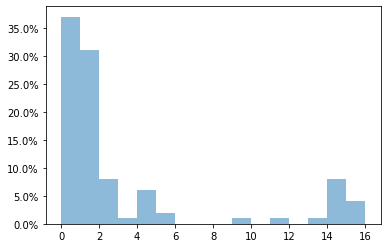

Time for epoch 145 is 4.9420201778411865 sec


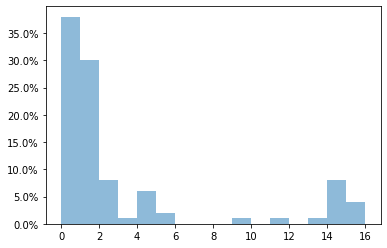

Time for epoch 146 is 4.98723840713501 sec


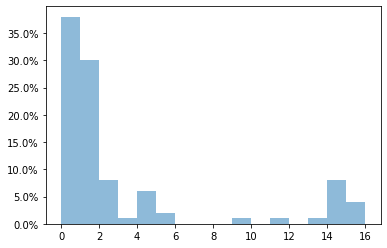

Time for epoch 147 is 5.0783467292785645 sec


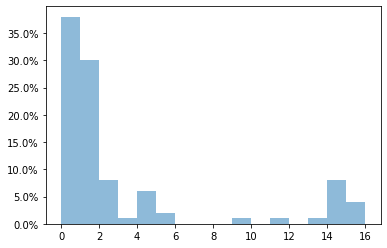

Time for epoch 148 is 5.051974296569824 sec


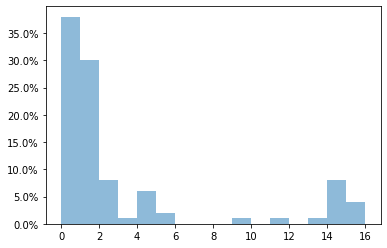

Time for epoch 149 is 4.871368885040283 sec


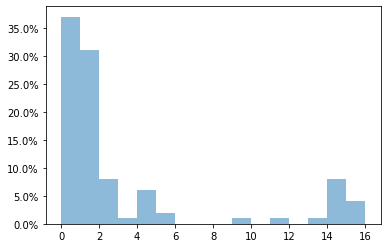

Time for epoch 150 is 5.082056760787964 sec


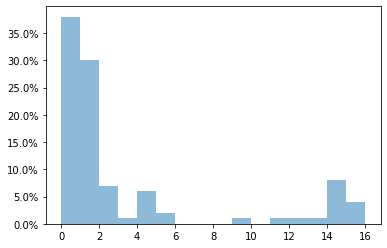

Time for epoch 151 is 4.951364517211914 sec


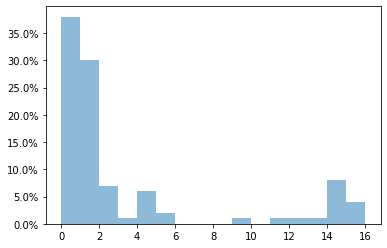

Time for epoch 152 is 4.96099328994751 sec


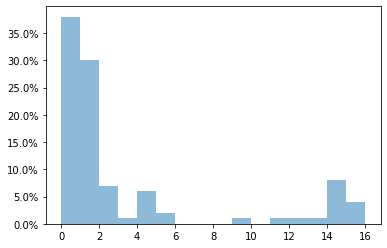

Time for epoch 153 is 5.071916818618774 sec


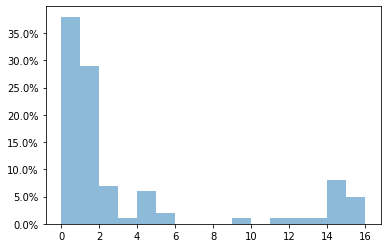

Time for epoch 154 is 4.96258020401001 sec


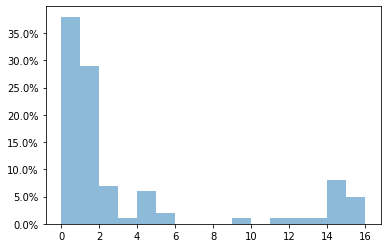

Time for epoch 155 is 4.918917417526245 sec


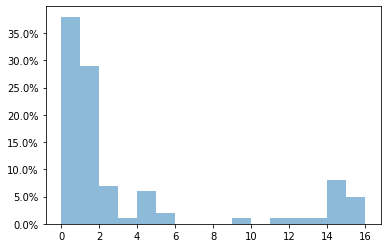

Time for epoch 156 is 5.121946811676025 sec


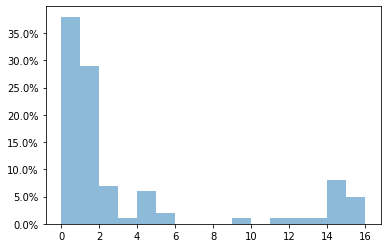

Time for epoch 157 is 4.979593753814697 sec


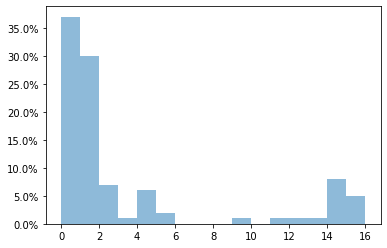

Time for epoch 158 is 4.9388298988342285 sec


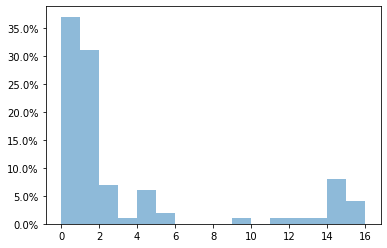

Time for epoch 159 is 5.046988010406494 sec


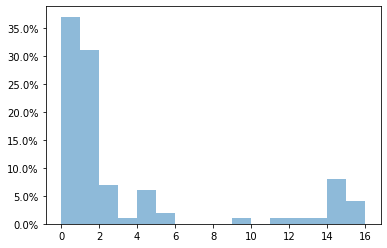

Time for epoch 160 is 4.9453651905059814 sec


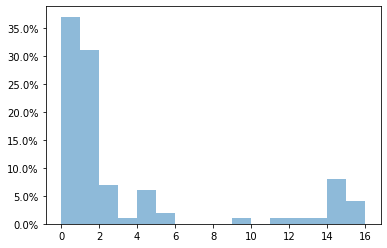

Time for epoch 161 is 4.94321870803833 sec


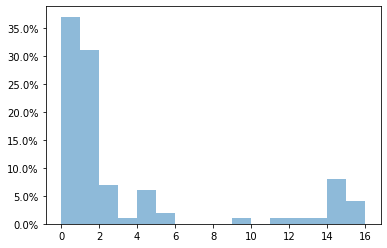

Time for epoch 162 is 5.069119453430176 sec


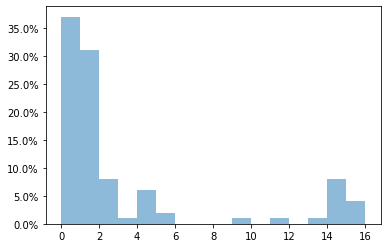

Time for epoch 163 is 5.276970863342285 sec


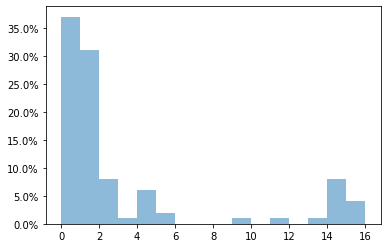

Time for epoch 164 is 5.390458583831787 sec


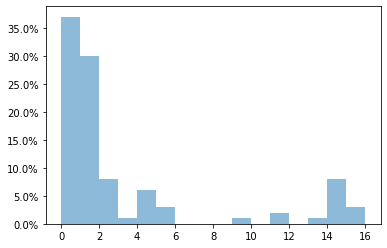

Time for epoch 165 is 4.977806329727173 sec


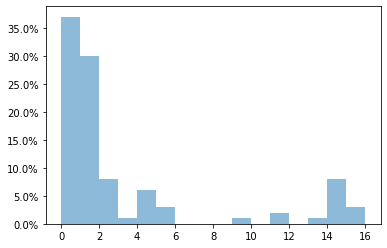

Time for epoch 166 is 5.061399459838867 sec


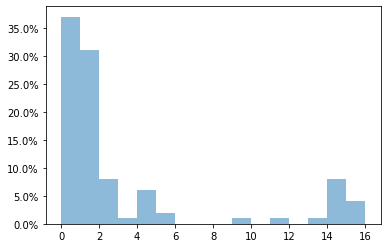

Time for epoch 167 is 4.998969554901123 sec


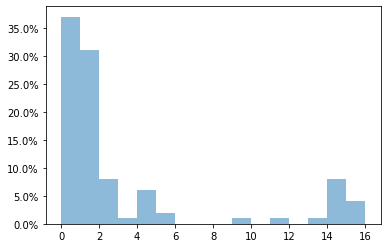

Time for epoch 168 is 4.953679084777832 sec


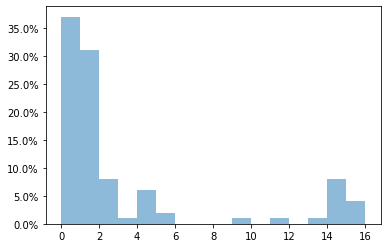

Time for epoch 169 is 5.0876593589782715 sec


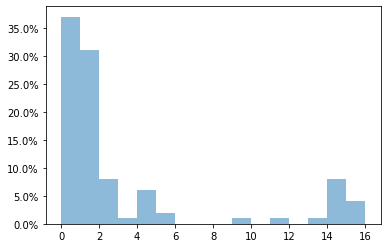

Time for epoch 170 is 5.046233654022217 sec


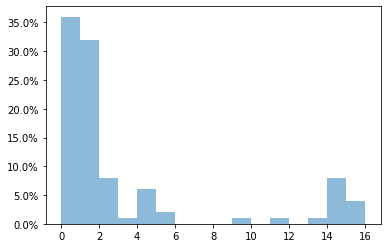

Time for epoch 171 is 4.998223304748535 sec


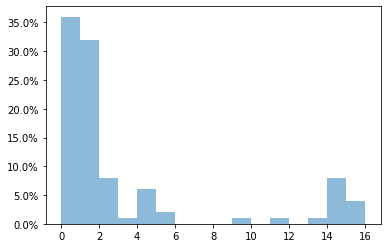

Time for epoch 172 is 5.222775220870972 sec


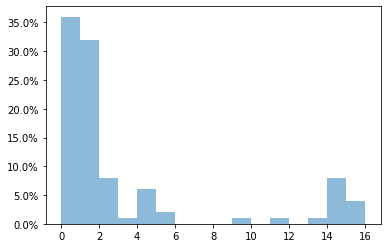

Time for epoch 173 is 5.040815591812134 sec


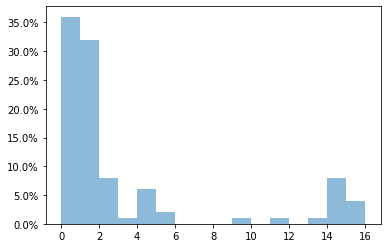

Time for epoch 174 is 5.022340536117554 sec


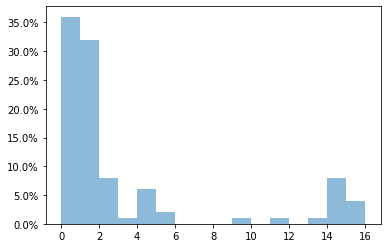

Time for epoch 175 is 5.131101846694946 sec


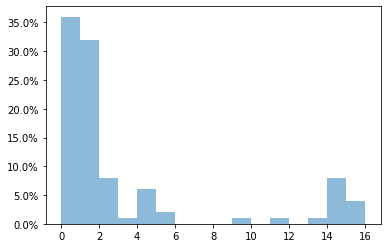

Time for epoch 176 is 4.9785706996917725 sec


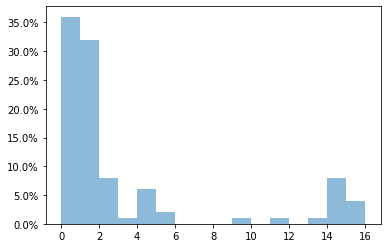

Time for epoch 177 is 5.162527084350586 sec


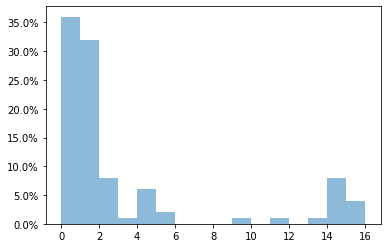

Time for epoch 178 is 5.072555065155029 sec


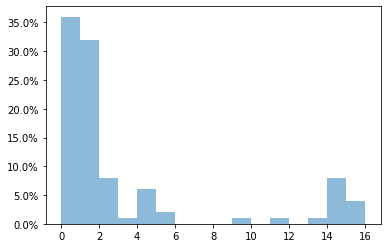

Time for epoch 179 is 4.947590112686157 sec


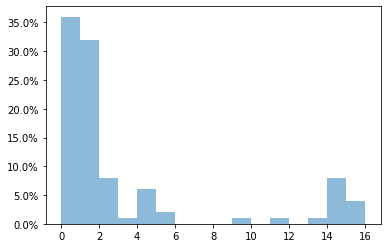

Time for epoch 180 is 4.949486970901489 sec


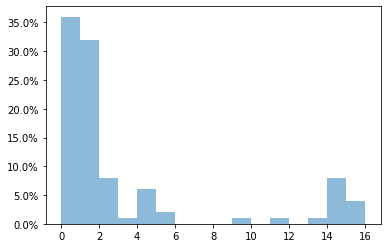

Time for epoch 181 is 4.957748174667358 sec


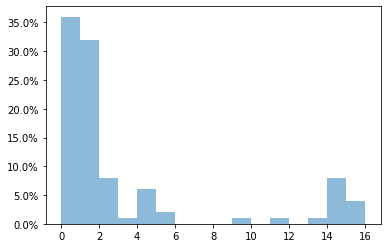

Time for epoch 182 is 5.058396100997925 sec


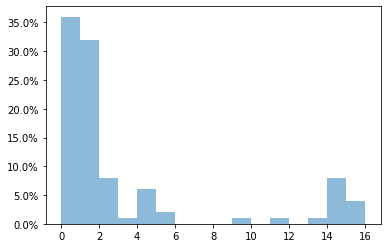

Time for epoch 183 is 4.970575332641602 sec


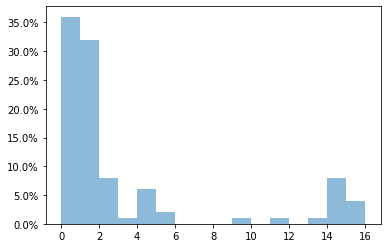

Time for epoch 184 is 4.943979501724243 sec


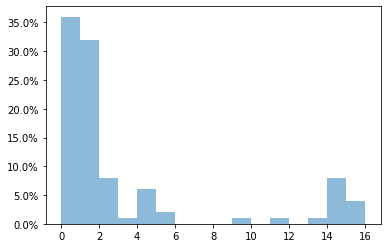

Time for epoch 185 is 5.031591176986694 sec


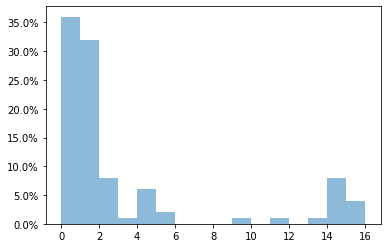

Time for epoch 186 is 4.994855165481567 sec


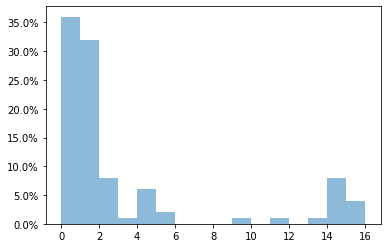

Time for epoch 187 is 4.915788888931274 sec


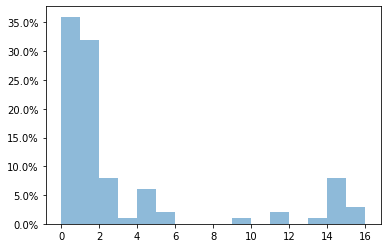

Time for epoch 188 is 5.074864625930786 sec


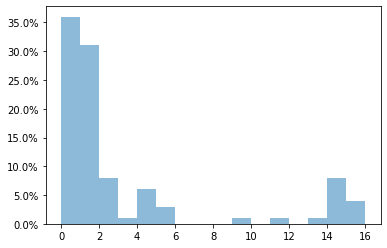

Time for epoch 189 is 4.95722508430481 sec


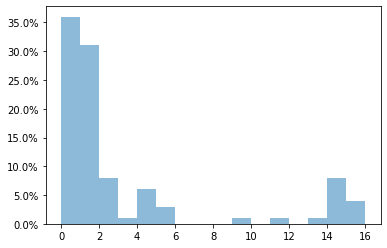

Time for epoch 190 is 5.024867057800293 sec


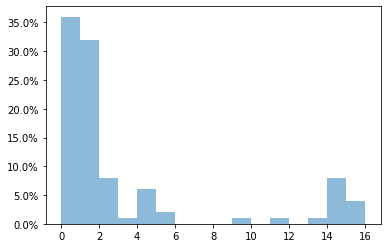

Time for epoch 191 is 5.051916599273682 sec


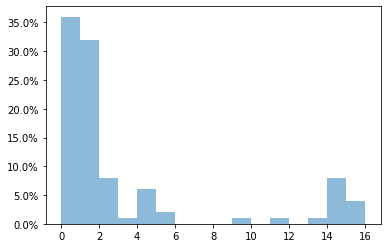

Time for epoch 192 is 4.986949920654297 sec


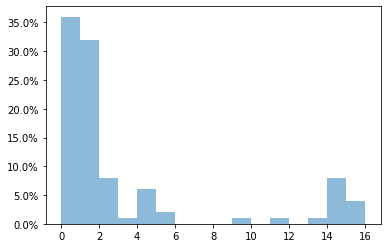

Time for epoch 193 is 4.952162742614746 sec


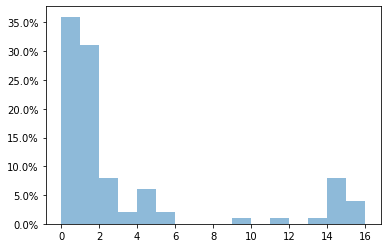

Time for epoch 194 is 5.138989210128784 sec


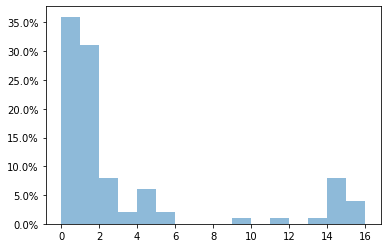

Time for epoch 195 is 4.939148187637329 sec


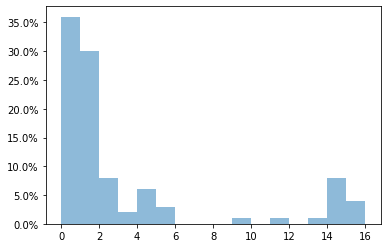

Time for epoch 196 is 4.522071838378906 sec


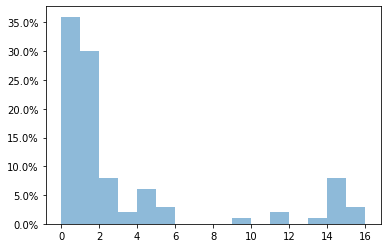

Time for epoch 197 is 5.015772581100464 sec


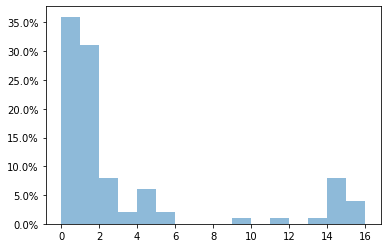

Time for epoch 198 is 5.031645059585571 sec


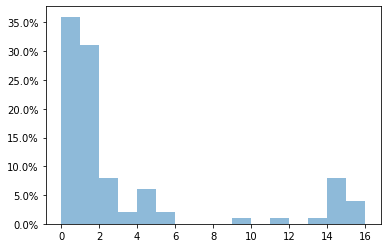

Time for epoch 199 is 4.967149972915649 sec


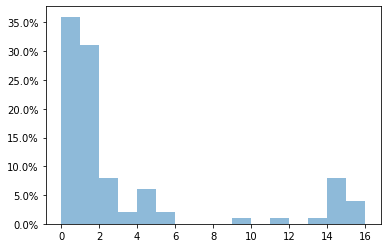

Time for epoch 200 is 4.9955174922943115 sec


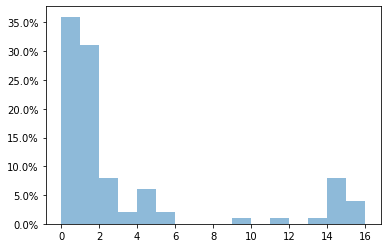

Time for epoch 201 is 5.001612901687622 sec


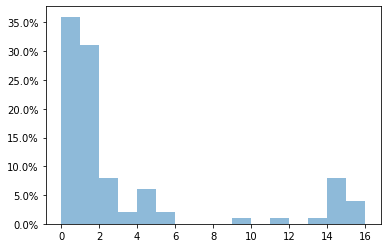

Time for epoch 202 is 4.900192022323608 sec


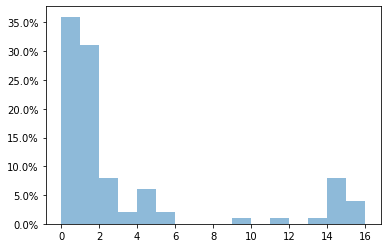

Time for epoch 203 is 4.924227476119995 sec


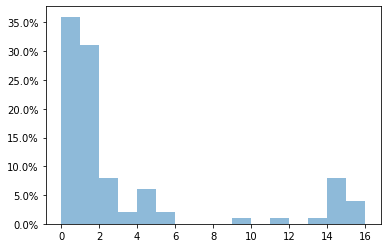

Time for epoch 204 is 5.0484654903411865 sec


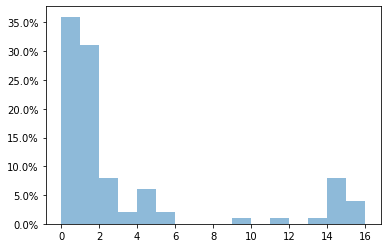

Time for epoch 205 is 4.927063703536987 sec


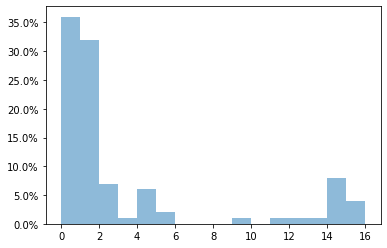

Time for epoch 206 is 4.94770622253418 sec


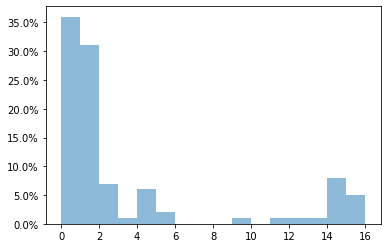

Time for epoch 207 is 5.068347215652466 sec


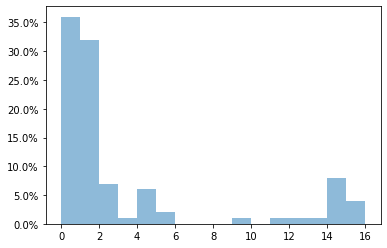

Time for epoch 208 is 4.932628631591797 sec


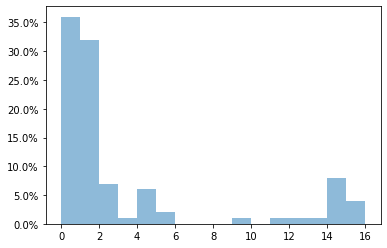

Time for epoch 209 is 4.963392734527588 sec


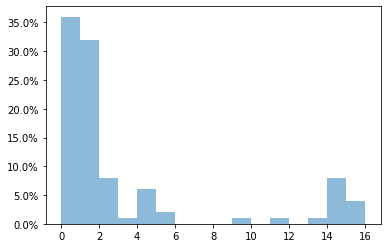

Time for epoch 210 is 5.065572261810303 sec


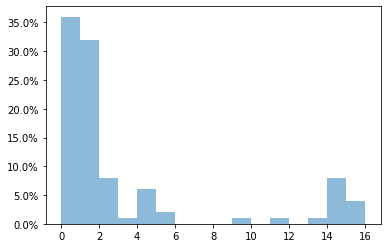

Time for epoch 211 is 4.946656703948975 sec


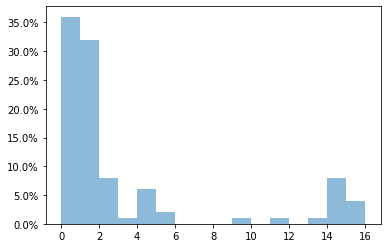

Time for epoch 212 is 4.952371597290039 sec


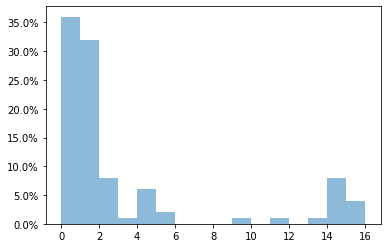

Time for epoch 213 is 4.908196449279785 sec


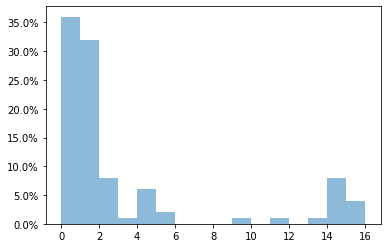

Time for epoch 214 is 5.019986391067505 sec


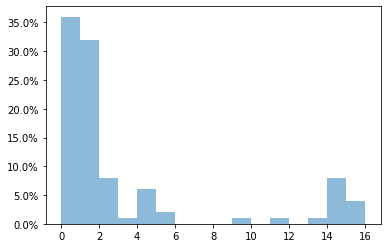

Time for epoch 215 is 4.952588319778442 sec


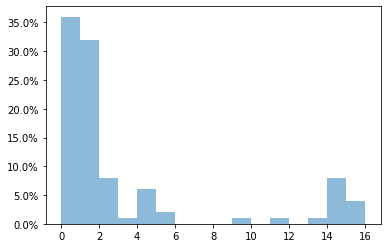

Time for epoch 216 is 5.209639310836792 sec


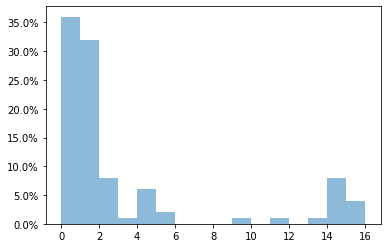

Time for epoch 217 is 5.0572309494018555 sec


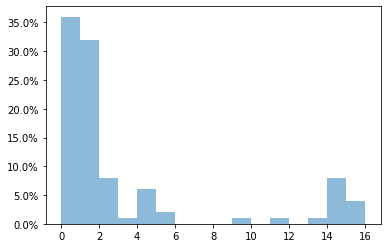

Time for epoch 218 is 4.986440896987915 sec


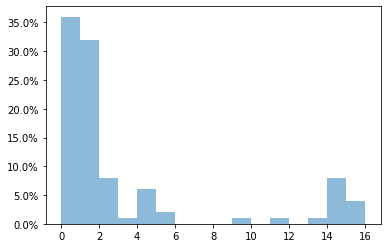

Time for epoch 219 is 4.940314769744873 sec


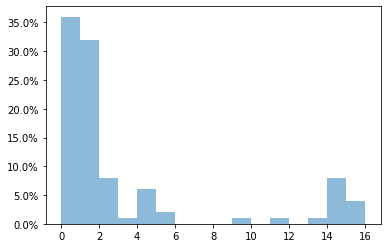

Time for epoch 220 is 5.109675884246826 sec


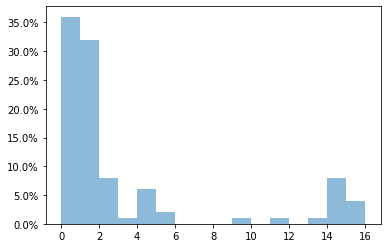

Time for epoch 221 is 4.924972772598267 sec


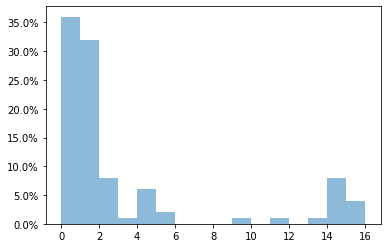

Time for epoch 222 is 4.929991245269775 sec


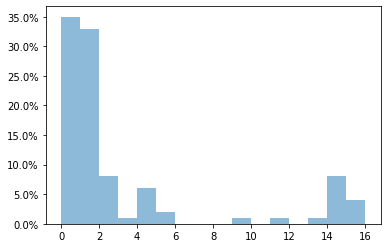

Time for epoch 223 is 5.075600862503052 sec


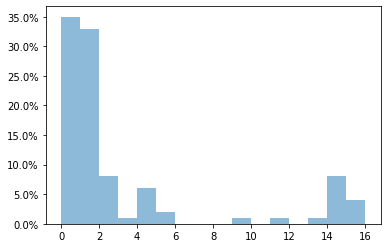

Time for epoch 224 is 5.114544153213501 sec


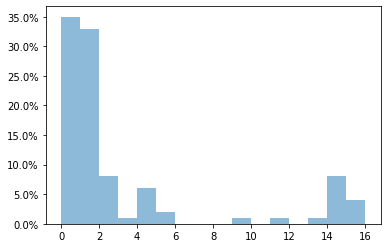

Time for epoch 225 is 4.917810678482056 sec


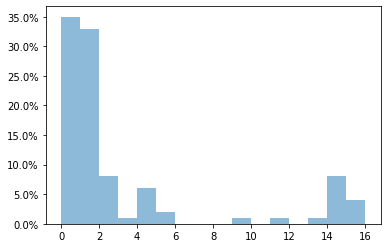

Time for epoch 226 is 4.998508453369141 sec


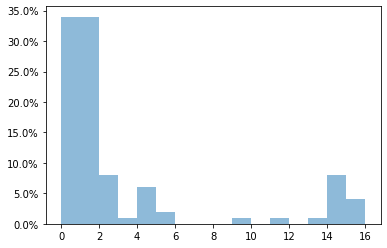

Time for epoch 227 is 4.964467287063599 sec


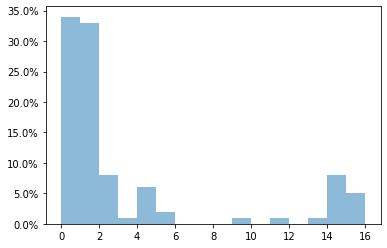

Time for epoch 228 is 4.934528350830078 sec


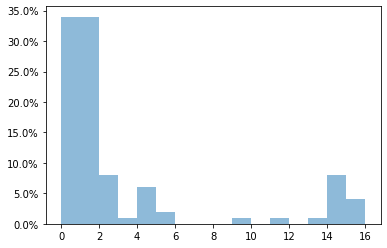

Time for epoch 229 is 4.94847846031189 sec


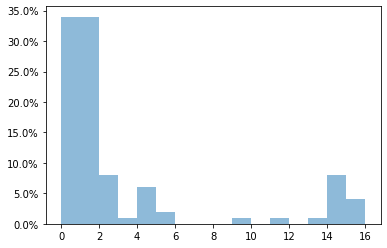

Time for epoch 230 is 5.024643659591675 sec


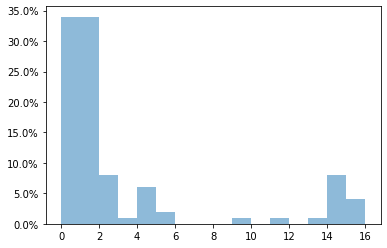

Time for epoch 231 is 4.911321401596069 sec


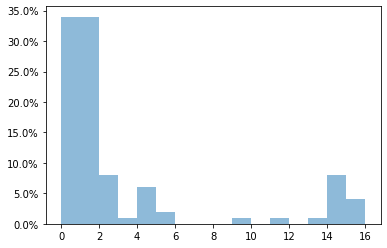

Time for epoch 232 is 5.004254341125488 sec


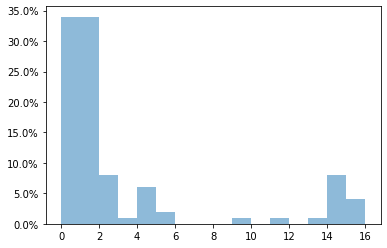

Time for epoch 233 is 4.107501268386841 sec


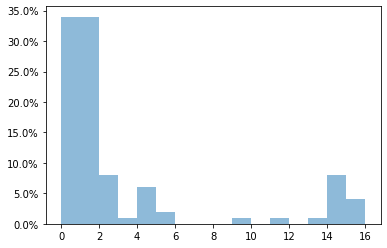

Time for epoch 234 is 4.0588059425354 sec


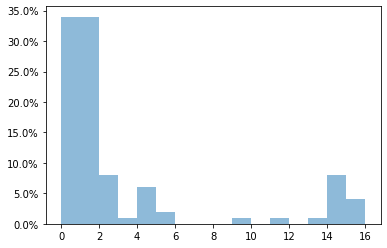

Time for epoch 235 is 4.055467128753662 sec


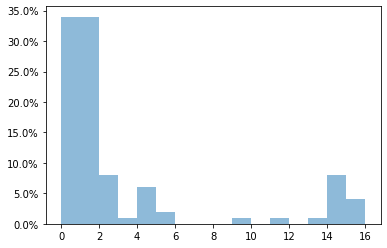

Time for epoch 236 is 4.049663066864014 sec


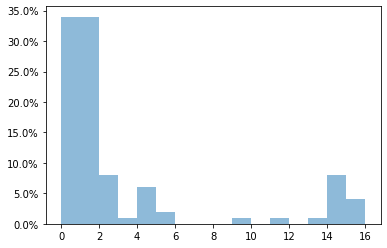

Time for epoch 237 is 4.2282750606536865 sec


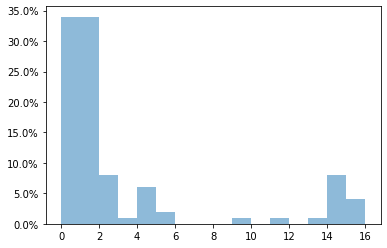

Time for epoch 238 is 4.019809246063232 sec


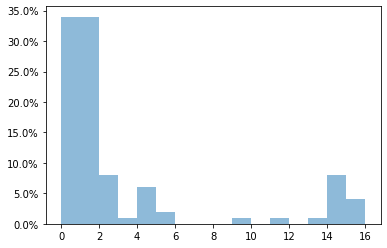

Time for epoch 239 is 4.0272417068481445 sec


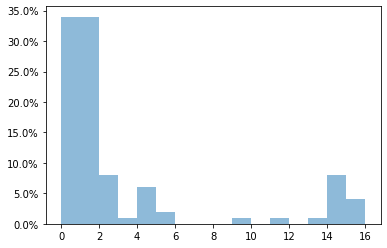

Time for epoch 240 is 4.217633008956909 sec


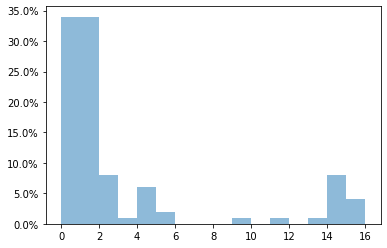

Time for epoch 241 is 4.183939218521118 sec


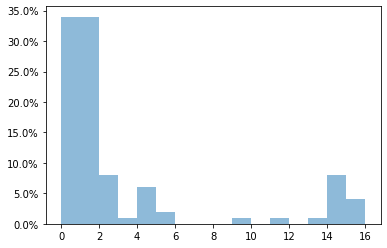

Time for epoch 242 is 4.030684232711792 sec


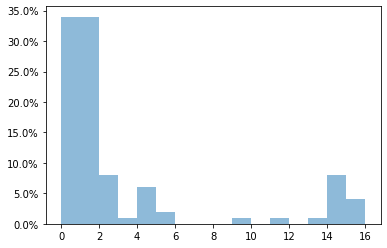

Time for epoch 243 is 4.006847143173218 sec


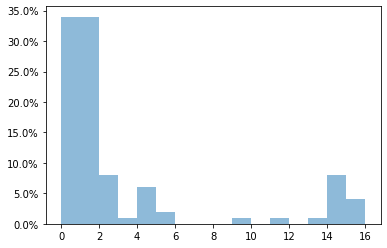

Time for epoch 244 is 4.0537590980529785 sec


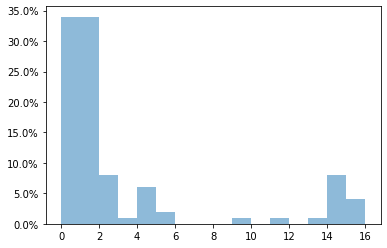

Time for epoch 245 is 4.0652313232421875 sec


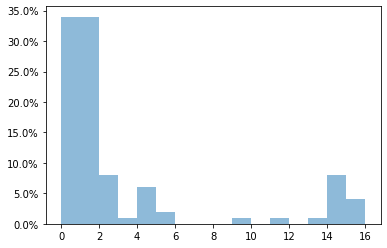

Time for epoch 246 is 3.9836697578430176 sec


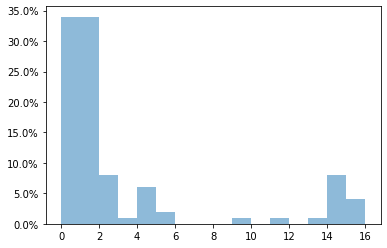

Time for epoch 247 is 4.076524019241333 sec


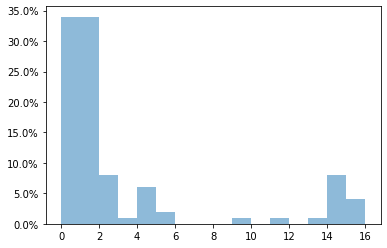

Time for epoch 248 is 4.029638051986694 sec


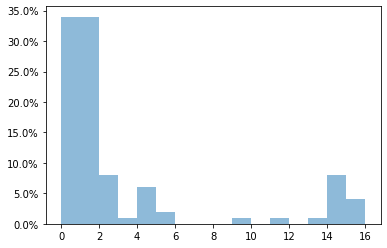

Time for epoch 249 is 4.0534515380859375 sec


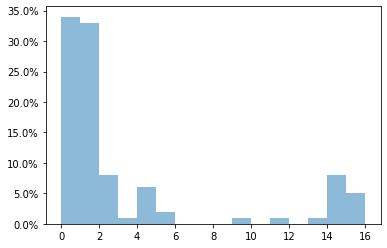

Time for epoch 250 is 4.062463045120239 sec


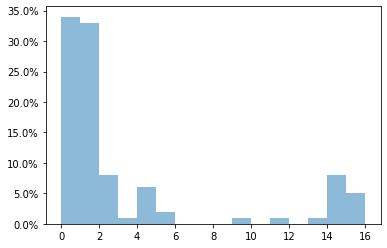

Time for epoch 251 is 4.021957874298096 sec


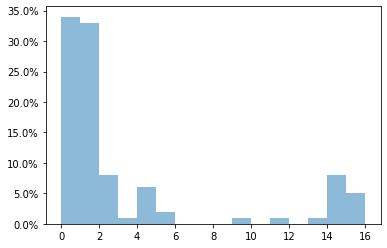

Time for epoch 252 is 4.061483860015869 sec


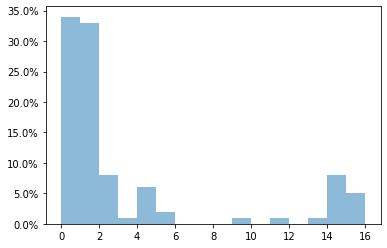

Time for epoch 253 is 4.034023761749268 sec


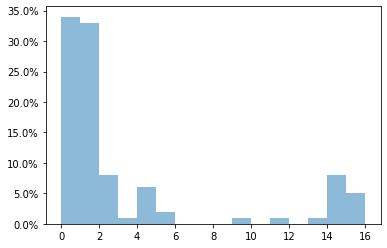

Time for epoch 254 is 4.006075620651245 sec


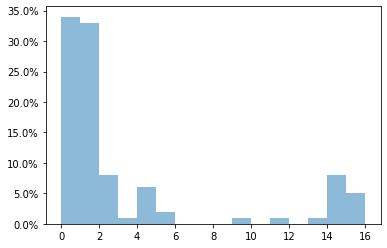

Time for epoch 255 is 3.9831085205078125 sec


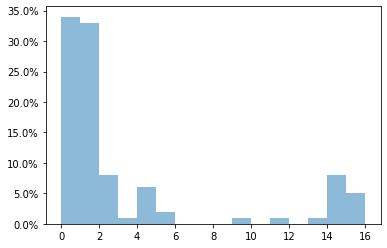

Time for epoch 256 is 4.03384804725647 sec


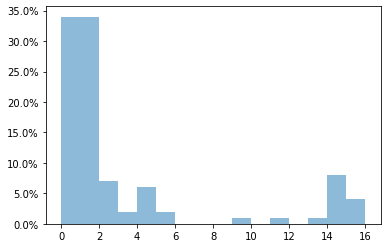

Time for epoch 257 is 4.064178943634033 sec


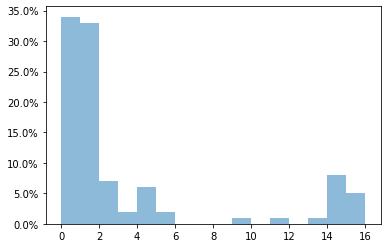

Time for epoch 258 is 4.051632642745972 sec


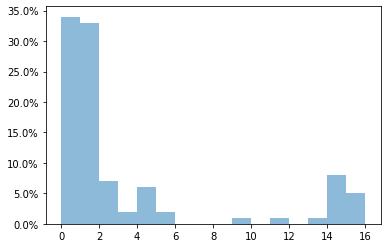

Time for epoch 259 is 4.077011585235596 sec


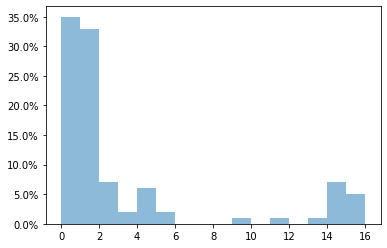

Time for epoch 260 is 4.028625249862671 sec


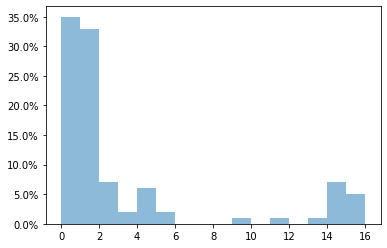

Time for epoch 261 is 4.011993646621704 sec


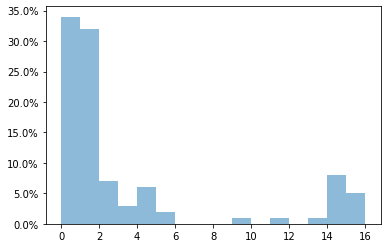

Time for epoch 262 is 3.9929556846618652 sec


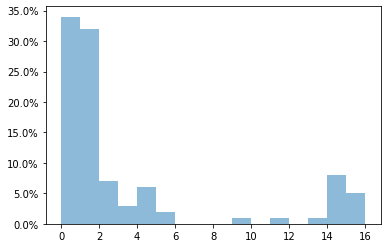

Time for epoch 263 is 4.027675151824951 sec


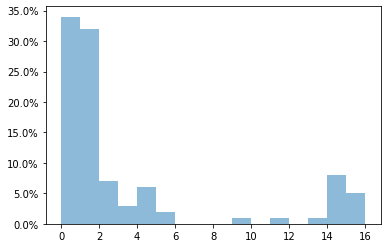

Time for epoch 264 is 4.105895757675171 sec


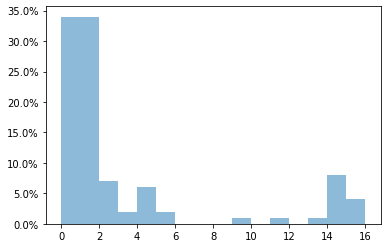

Time for epoch 265 is 4.032817125320435 sec


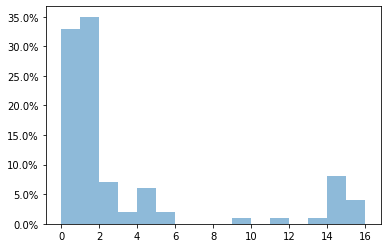

Time for epoch 266 is 3.9899473190307617 sec


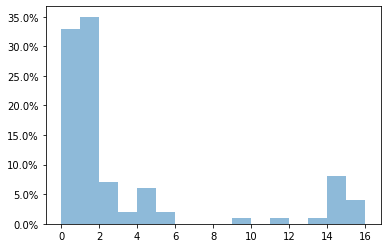

Time for epoch 267 is 3.9912781715393066 sec


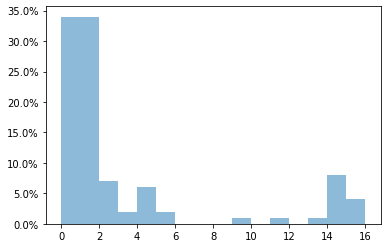

Time for epoch 268 is 4.06215238571167 sec


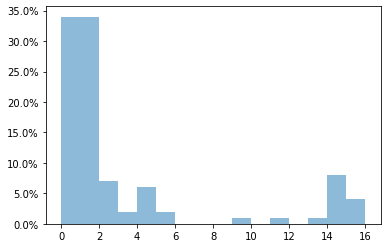

Time for epoch 269 is 4.011734485626221 sec


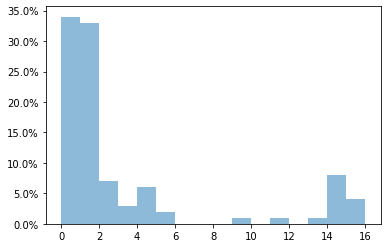

Time for epoch 270 is 4.035667181015015 sec


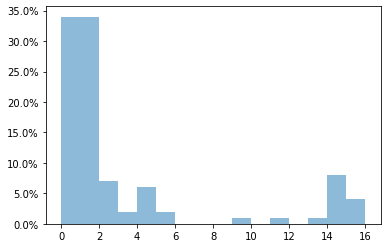

Time for epoch 271 is 4.200294256210327 sec


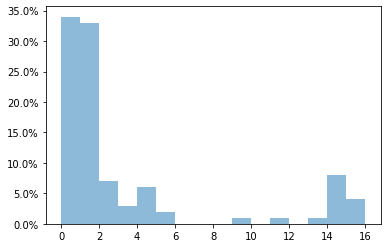

Time for epoch 272 is 4.065533638000488 sec


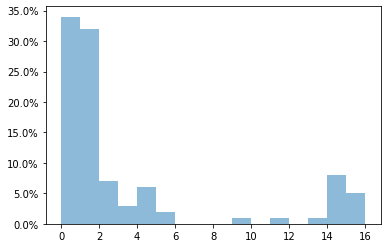

Time for epoch 273 is 4.0367748737335205 sec


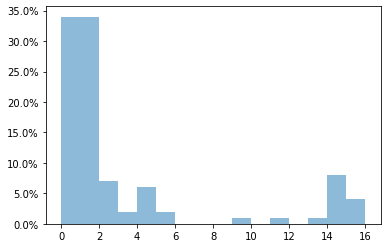

Time for epoch 274 is 4.1474034786224365 sec


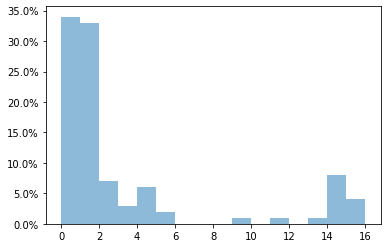

Time for epoch 275 is 4.02142596244812 sec


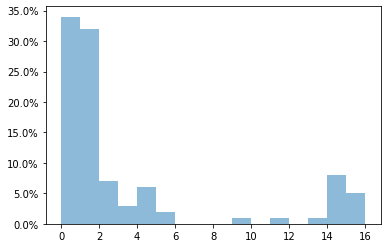

Time for epoch 276 is 4.100541830062866 sec


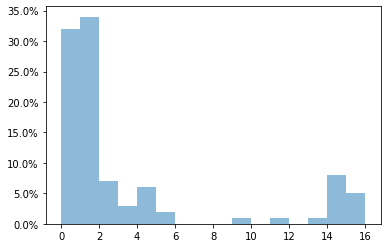

Time for epoch 277 is 4.297951936721802 sec


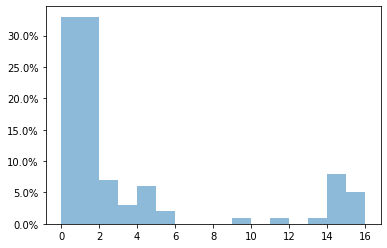

Time for epoch 278 is 4.002321481704712 sec


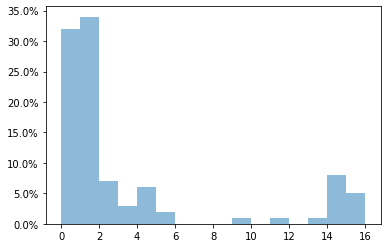

Time for epoch 279 is 4.036559581756592 sec


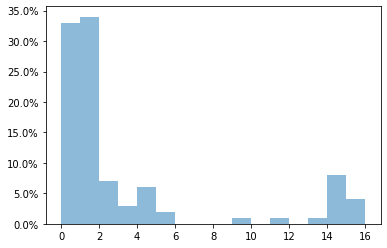

Time for epoch 280 is 4.110052585601807 sec


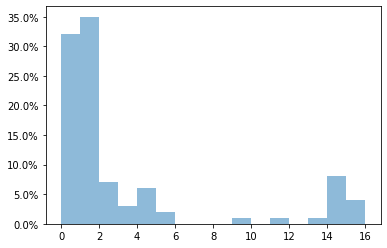

Time for epoch 281 is 4.246548175811768 sec


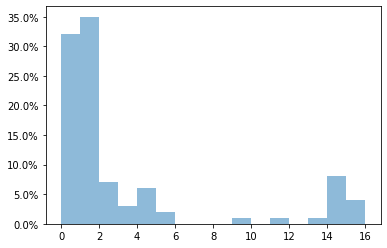

Time for epoch 282 is 4.0588202476501465 sec


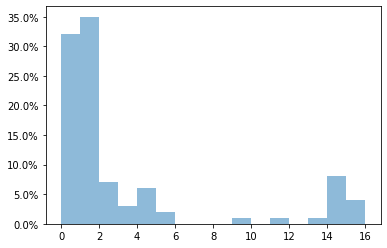

Time for epoch 283 is 4.028758525848389 sec


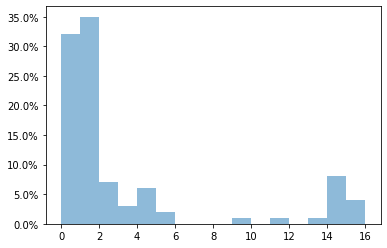

Time for epoch 284 is 4.076806545257568 sec


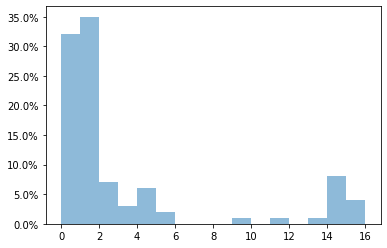

Time for epoch 285 is 4.088489770889282 sec


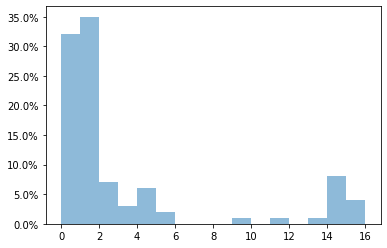

Time for epoch 286 is 4.062662124633789 sec


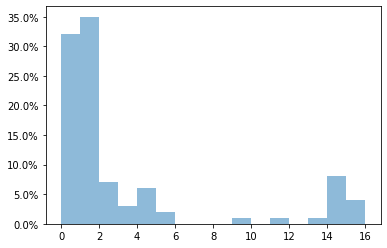

Time for epoch 287 is 4.059930086135864 sec


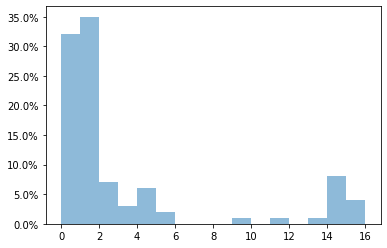

Time for epoch 288 is 4.079264879226685 sec


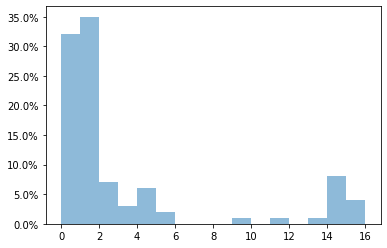

Time for epoch 289 is 4.1517333984375 sec


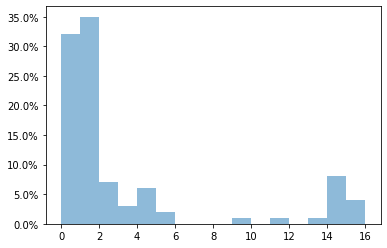

Time for epoch 290 is 4.071431636810303 sec


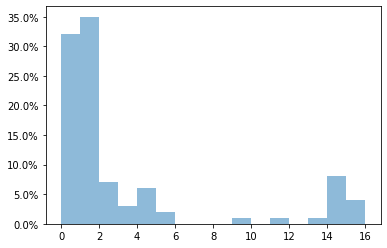

Time for epoch 291 is 4.021827220916748 sec


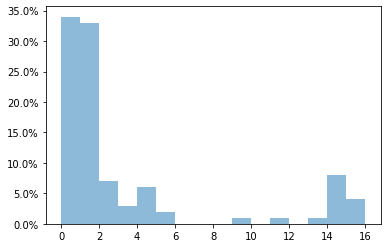

Time for epoch 292 is 4.053514719009399 sec


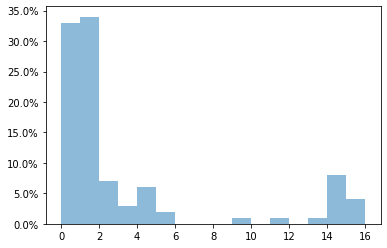

Time for epoch 293 is 4.06110954284668 sec


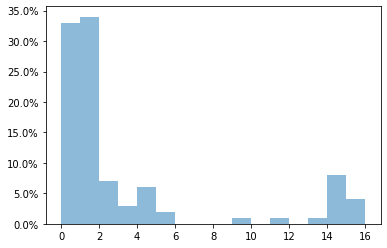

Time for epoch 294 is 4.034659147262573 sec


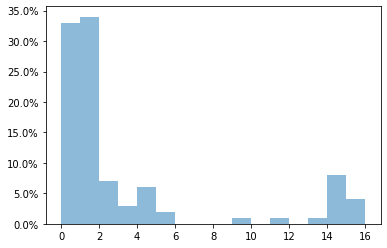

Time for epoch 295 is 4.024489164352417 sec


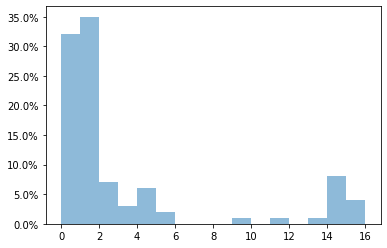

Time for epoch 296 is 4.259521722793579 sec


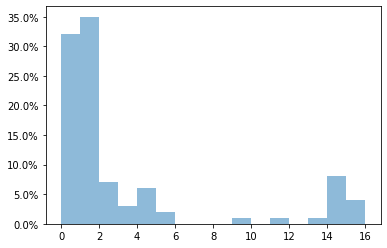

Time for epoch 297 is 4.028177261352539 sec


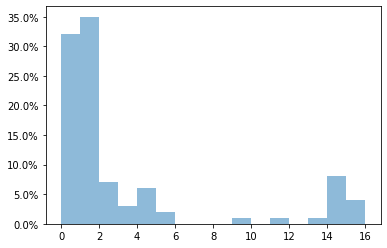

Time for epoch 298 is 4.027639865875244 sec


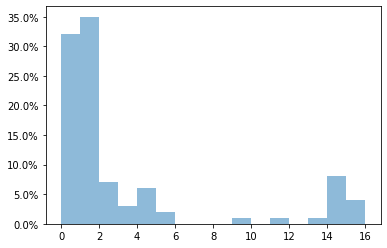

Time for epoch 299 is 4.014293670654297 sec


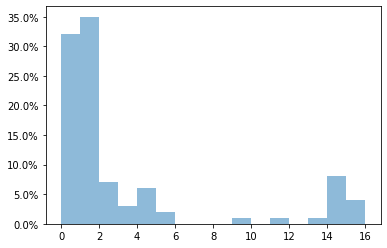

Time for epoch 300 is 4.055050849914551 sec


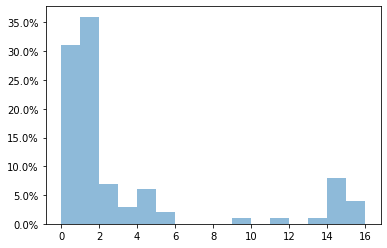

Time for epoch 301 is 4.021566390991211 sec


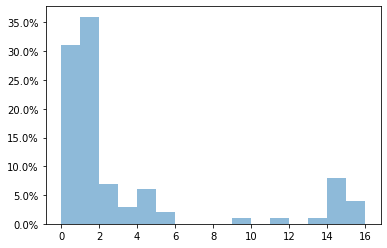

Time for epoch 302 is 4.061521053314209 sec


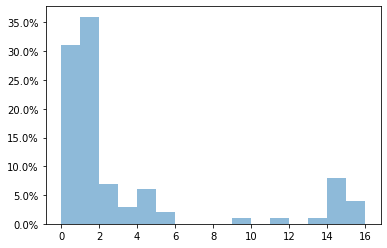

Time for epoch 303 is 4.036003351211548 sec


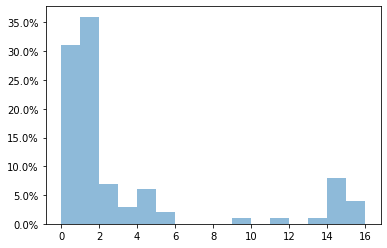

Time for epoch 304 is 4.054085969924927 sec


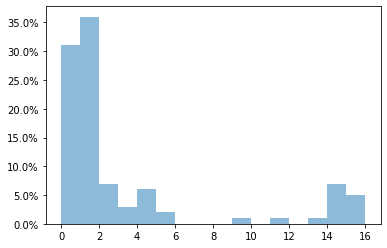

Time for epoch 305 is 4.0614073276519775 sec


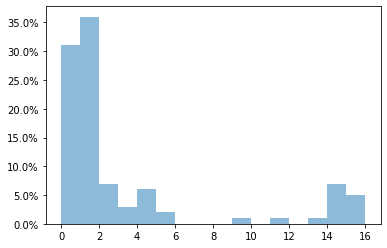

Time for epoch 306 is 4.056452751159668 sec


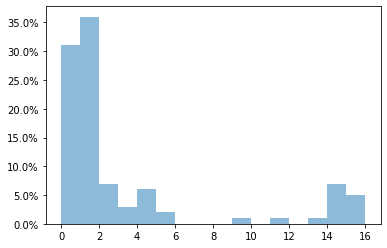

Time for epoch 307 is 4.014376878738403 sec


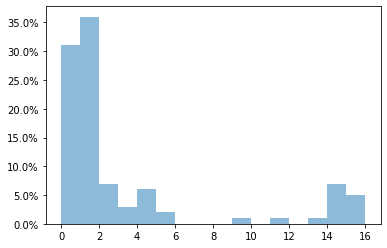

Time for epoch 308 is 4.043603420257568 sec


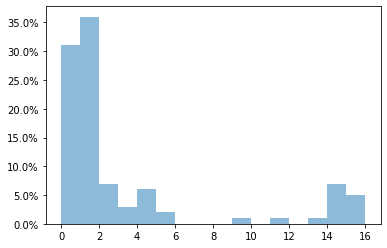

Time for epoch 309 is 4.020013332366943 sec


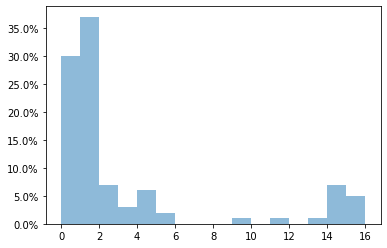

Time for epoch 310 is 4.0475335121154785 sec


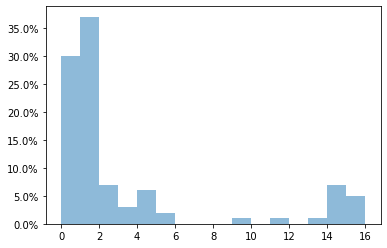

Time for epoch 311 is 4.033596992492676 sec


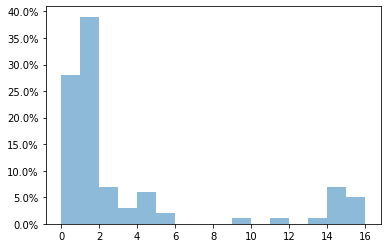

Time for epoch 312 is 4.104593515396118 sec


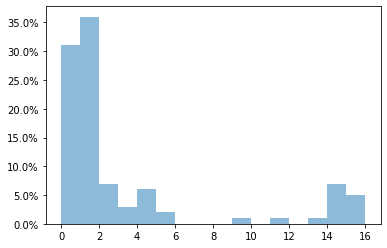

Time for epoch 313 is 4.146325349807739 sec


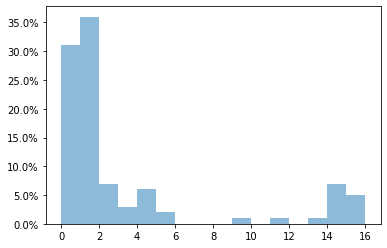

Time for epoch 314 is 4.118408679962158 sec


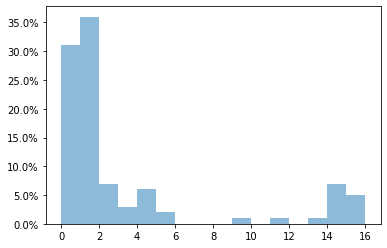

Time for epoch 315 is 4.039154529571533 sec


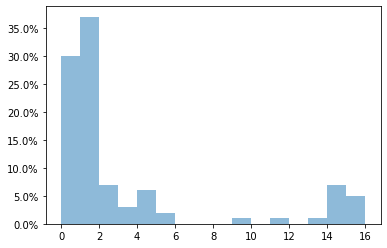

Time for epoch 316 is 4.06345009803772 sec


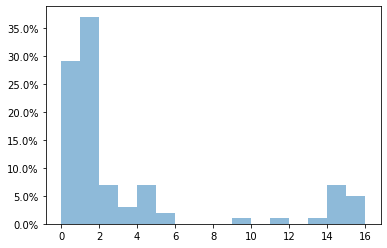

Time for epoch 317 is 3.987016439437866 sec


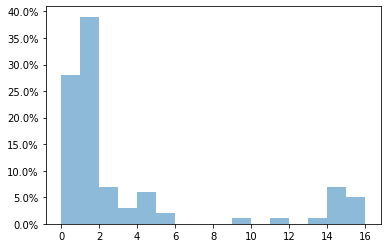

Time for epoch 318 is 4.045884370803833 sec


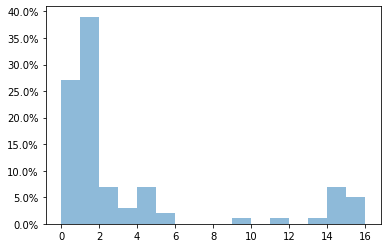

Time for epoch 319 is 4.091638803482056 sec


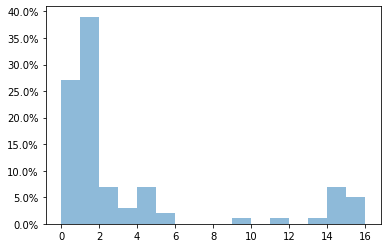

Time for epoch 320 is 5.957842111587524 sec


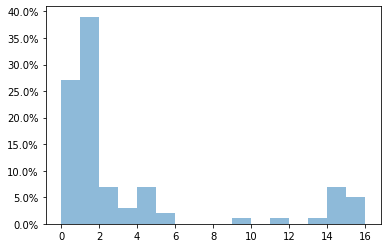

Time for epoch 321 is 4.043612480163574 sec


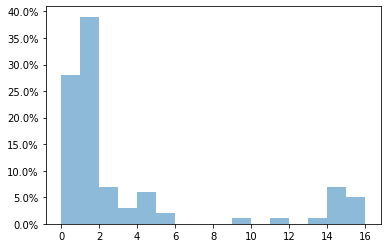

Time for epoch 322 is 3.984370231628418 sec


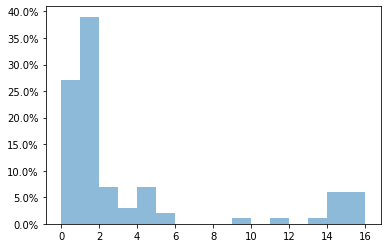

Time for epoch 323 is 4.146952152252197 sec


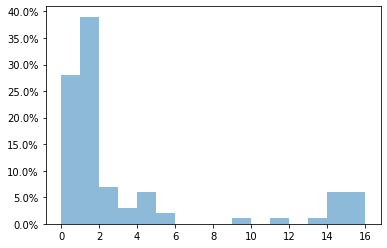

Time for epoch 324 is 4.026112794876099 sec


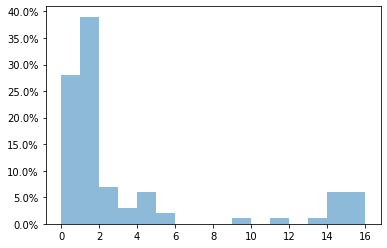

Time for epoch 325 is 4.049731731414795 sec


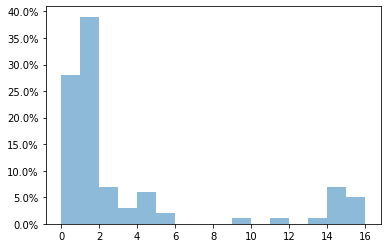

Time for epoch 326 is 4.011778831481934 sec


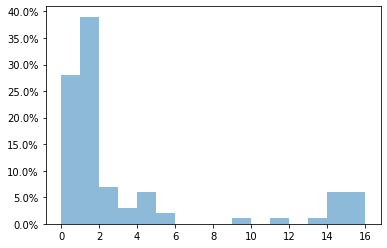

Time for epoch 327 is 4.079019546508789 sec


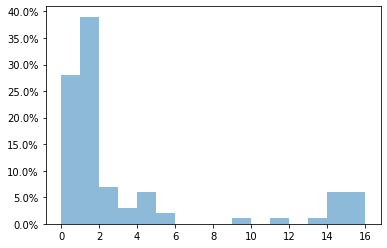

Time for epoch 328 is 4.004073143005371 sec


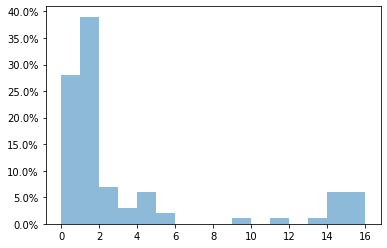

Time for epoch 329 is 4.052715063095093 sec


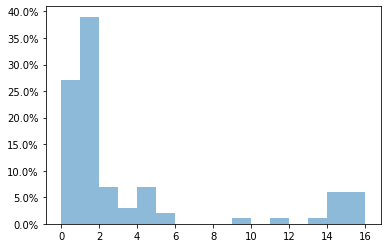

Time for epoch 330 is 4.086773633956909 sec


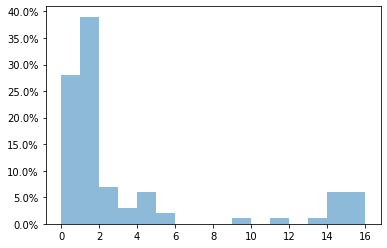

Time for epoch 331 is 4.083680152893066 sec


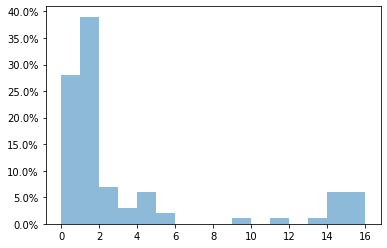

Time for epoch 332 is 4.0142927169799805 sec


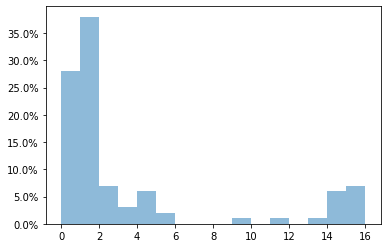

Time for epoch 333 is 4.012666463851929 sec


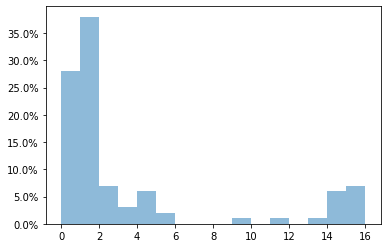

Time for epoch 334 is 4.008449077606201 sec


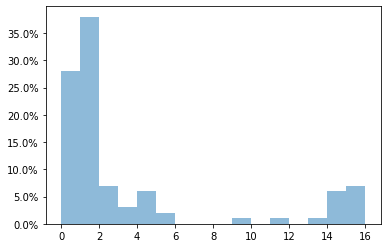

Time for epoch 335 is 4.151091814041138 sec


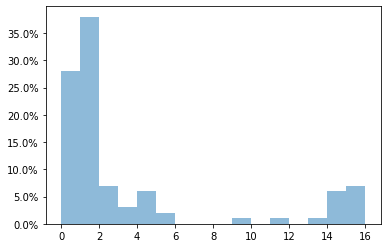

Time for epoch 336 is 4.08522891998291 sec


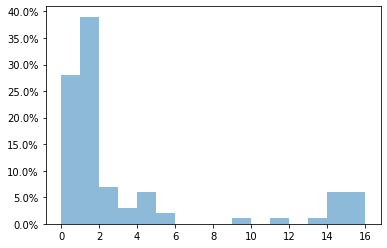

Time for epoch 337 is 4.081873416900635 sec


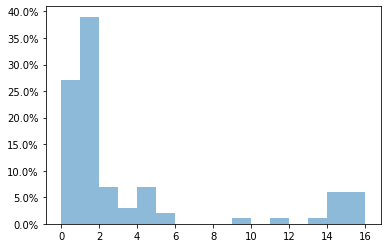

Time for epoch 338 is 4.0270445346832275 sec


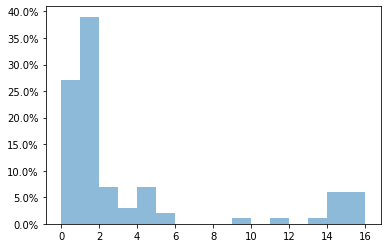

Time for epoch 339 is 4.056108713150024 sec


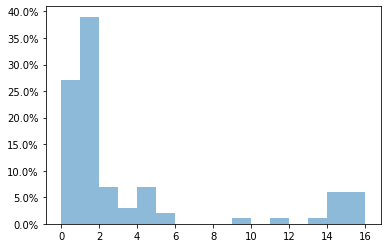

Time for epoch 340 is 4.0489397048950195 sec


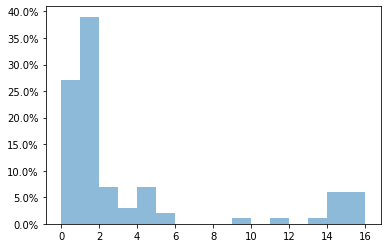

Time for epoch 341 is 4.021750211715698 sec


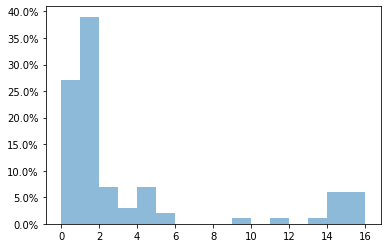

Time for epoch 342 is 4.073838472366333 sec


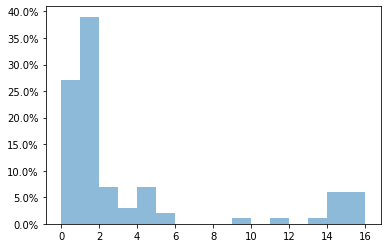

Time for epoch 343 is 4.1135852336883545 sec


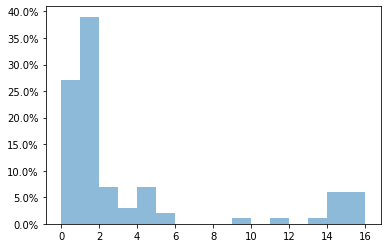

Time for epoch 344 is 4.020536422729492 sec


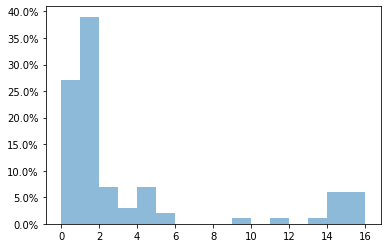

Time for epoch 345 is 4.048880338668823 sec


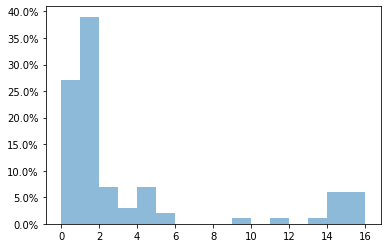

Time for epoch 346 is 4.087465524673462 sec


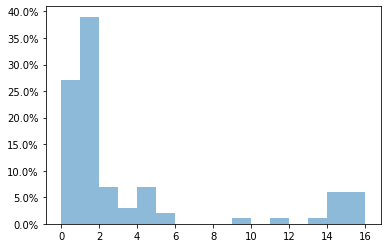

Time for epoch 347 is 4.113306045532227 sec


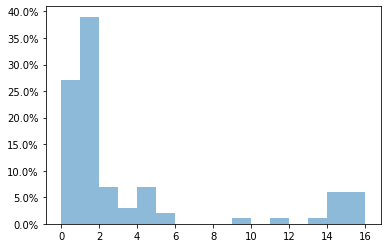

Time for epoch 348 is 4.074976444244385 sec


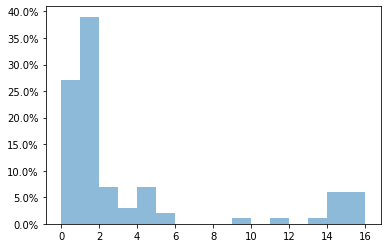

Time for epoch 349 is 3.992388963699341 sec


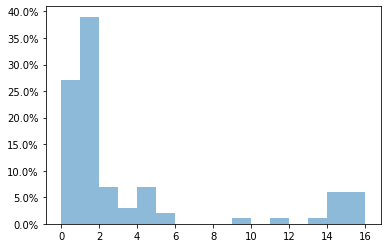

Time for epoch 350 is 4.043282508850098 sec


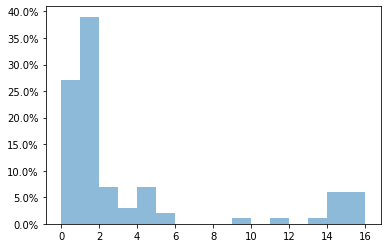

Time for epoch 351 is 4.047593116760254 sec


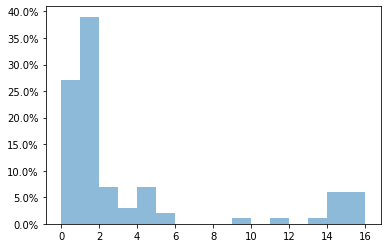

Time for epoch 352 is 4.0219292640686035 sec


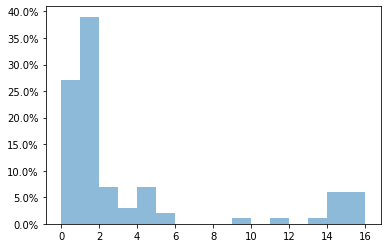

Time for epoch 353 is 4.060921669006348 sec


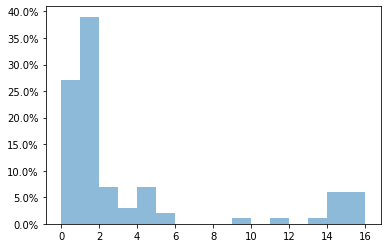

Time for epoch 354 is 4.065535545349121 sec


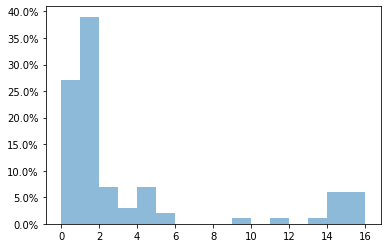

Time for epoch 355 is 4.069221496582031 sec


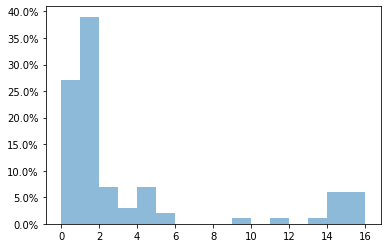

Time for epoch 356 is 4.015027046203613 sec


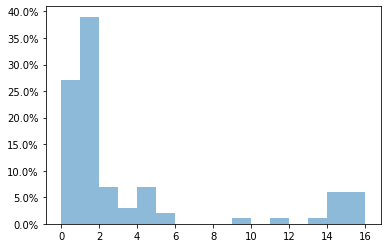

Time for epoch 357 is 4.0717079639434814 sec


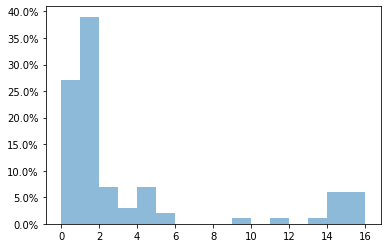

Time for epoch 358 is 4.069688558578491 sec


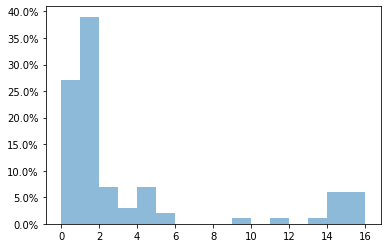

Time for epoch 359 is 4.0897369384765625 sec


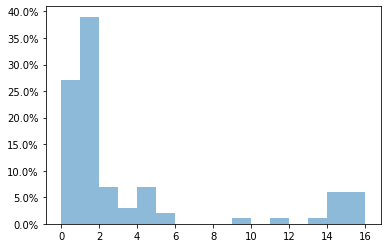

Time for epoch 360 is 4.035130739212036 sec


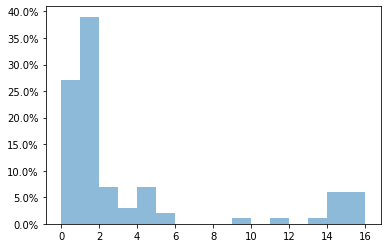

Time for epoch 361 is 4.09013819694519 sec


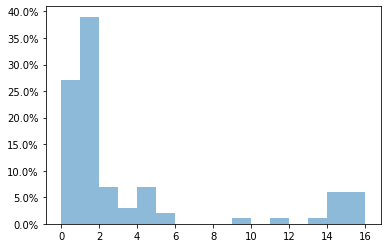

Time for epoch 362 is 4.076567649841309 sec


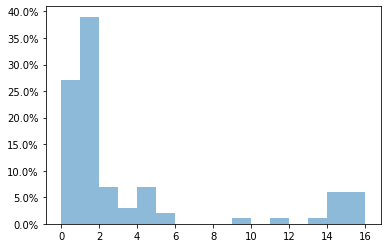

Time for epoch 363 is 4.042278289794922 sec


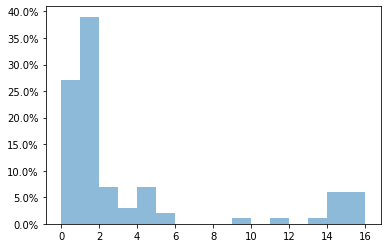

Time for epoch 364 is 4.03332257270813 sec


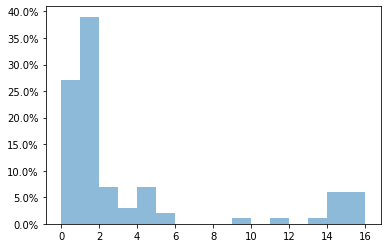

Time for epoch 365 is 4.0277955532073975 sec


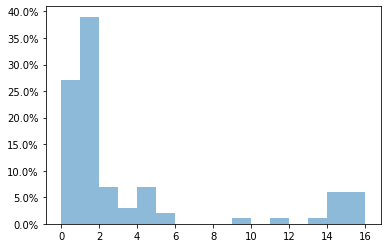

Time for epoch 366 is 4.076243877410889 sec


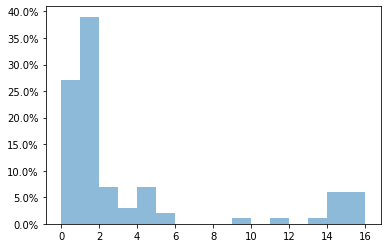

Time for epoch 367 is 4.0359978675842285 sec


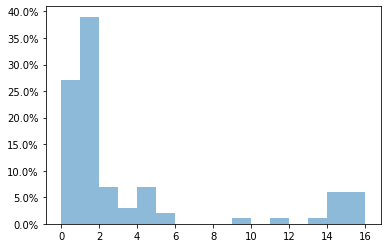

Time for epoch 368 is 4.048454761505127 sec


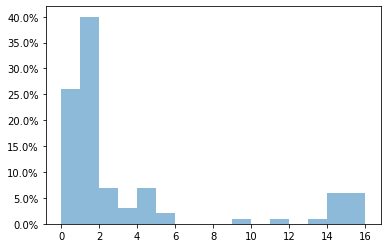

Time for epoch 369 is 3.992485284805298 sec


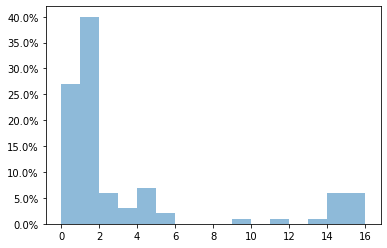

Time for epoch 370 is 4.074275255203247 sec


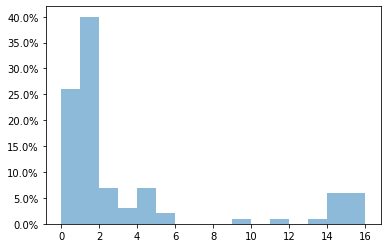

Time for epoch 371 is 4.02148699760437 sec


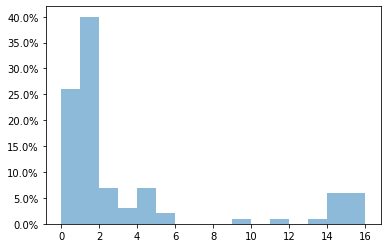

Time for epoch 372 is 4.056775808334351 sec


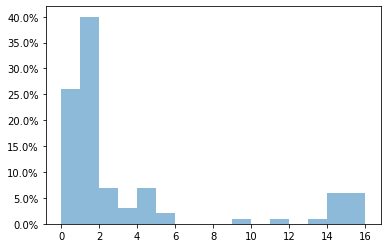

Time for epoch 373 is 4.0066022872924805 sec


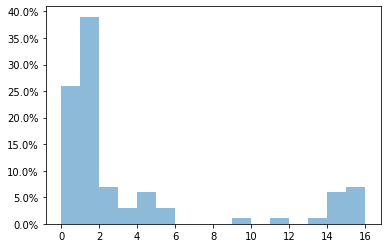

Time for epoch 374 is 4.034780502319336 sec


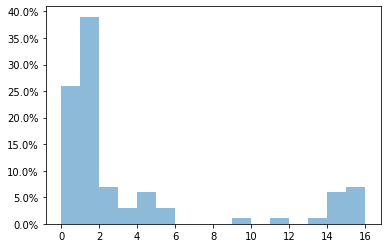

Time for epoch 375 is 4.049127101898193 sec


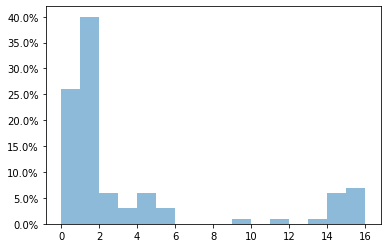

Time for epoch 376 is 4.069230079650879 sec


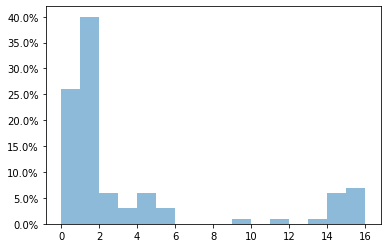

Time for epoch 377 is 3.9992051124572754 sec


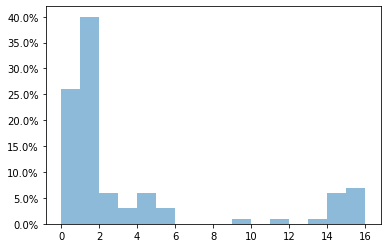

Time for epoch 378 is 4.11784815788269 sec


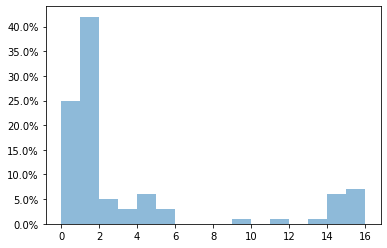

Time for epoch 379 is 4.021453380584717 sec


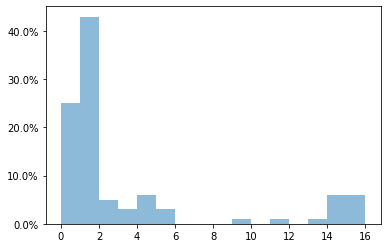

Time for epoch 380 is 4.005683422088623 sec


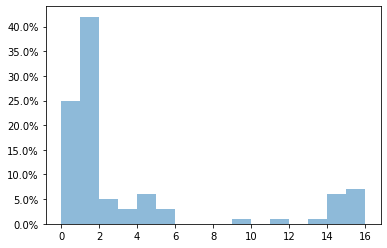

Time for epoch 381 is 4.048639297485352 sec


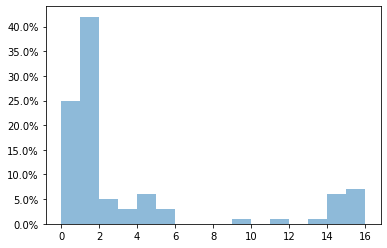

Time for epoch 382 is 4.139745473861694 sec


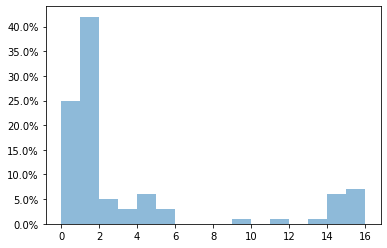

Time for epoch 383 is 4.020303964614868 sec


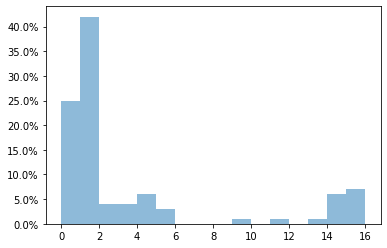

Time for epoch 384 is 4.040382623672485 sec


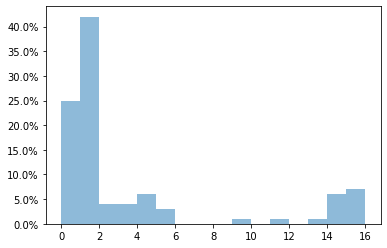

Time for epoch 385 is 4.037583112716675 sec


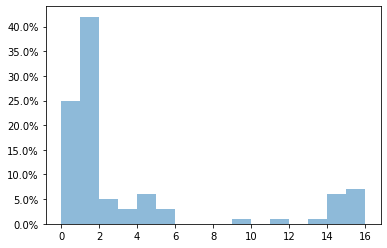

Time for epoch 386 is 4.08806848526001 sec


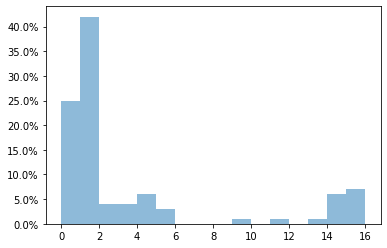

Time for epoch 387 is 4.028048992156982 sec


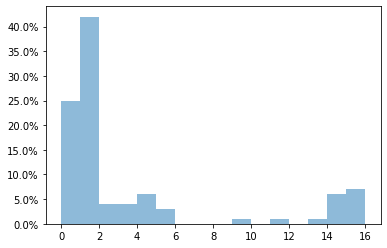

Time for epoch 388 is 4.034642934799194 sec


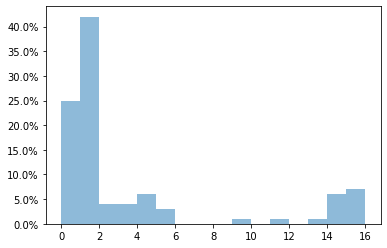

Time for epoch 389 is 4.000459671020508 sec


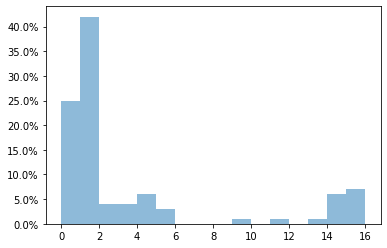

Time for epoch 390 is 4.103214979171753 sec


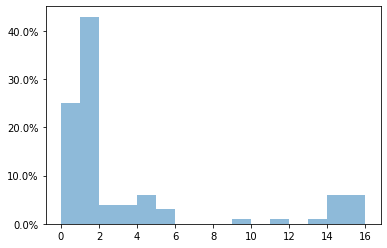

Time for epoch 391 is 3.972405433654785 sec


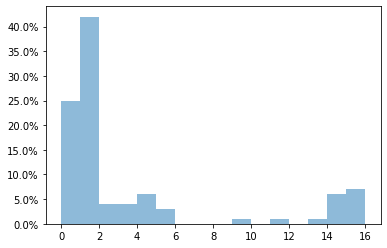

Time for epoch 392 is 4.048535585403442 sec


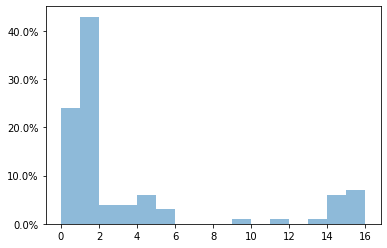

Time for epoch 393 is 3.986020088195801 sec


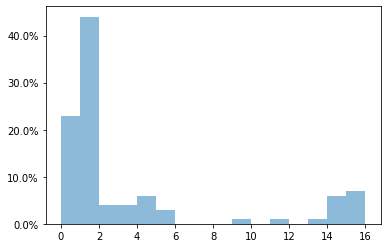

Time for epoch 394 is 4.139434814453125 sec


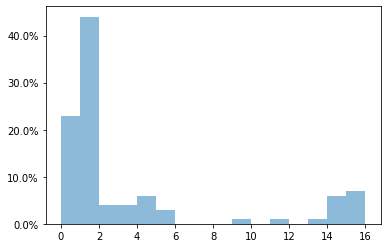

Time for epoch 395 is 4.095590591430664 sec


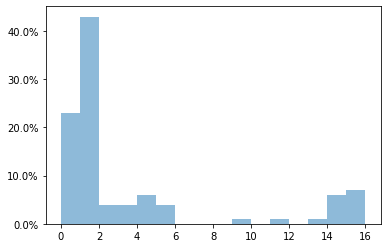

Time for epoch 396 is 4.254946947097778 sec


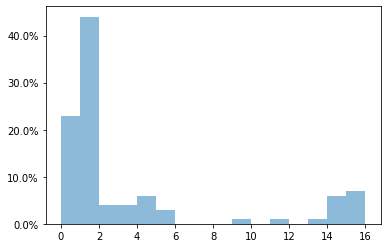

Time for epoch 397 is 4.009441375732422 sec


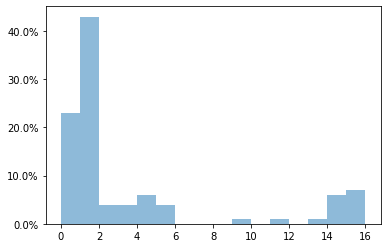

Time for epoch 398 is 4.020721435546875 sec


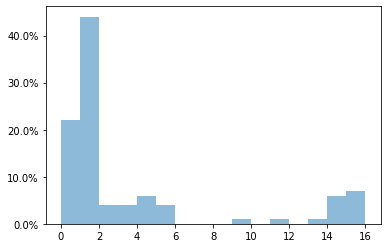

Time for epoch 399 is 3.9747323989868164 sec


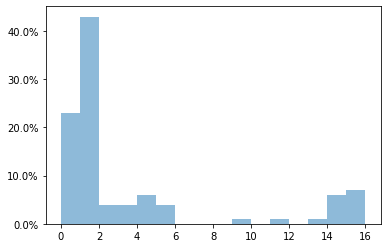

Time for epoch 400 is 3.9627058506011963 sec


In [23]:
train(data_loader, EPOCHS)

In [24]:
noise = tf.random.normal([100, 4])
generated_data = generator(noise, training=False).numpy()
generated_data = np.argmax(generated_data,1)

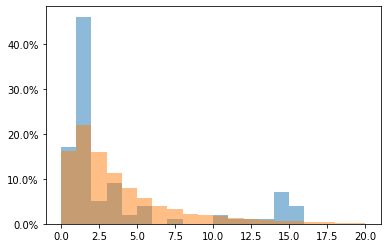

In [25]:
plt.hist(generated_data , bins = 20,  range=(0, 20), alpha=0.5, weights=np.ones(len(generated_data)) / len(generated_data))
plt.hist(data , bins = 20,  range=(0, 20), alpha=0.5, weights=np.ones(len(data)) / len(data))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()